### Load packages

In [20]:
import sys
sys.path.append('~/MAP-CF/')  # path that contains cf_search
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, json, io, os
import importlib
import cf_search.visualize
importlib.reload(cf_search.visualize)

# Now re-import your function
from cf_search.visualize import plot_cf_kde_cell


from cf_search.visualize import (
    extract_cell_data,
    plot_counterfactuals,
    plot_fitness_heatmap,
    plot_all_pcas_grid,
    plot_all_pcas_grid_by_cluster,
    plot_all_clusters_by_heatmap,
    plot_all_mutable_clusters_by_heatmap,
    plot_cf_clustermap_cell,
    plot_cf_umap_cell,
    plot_cf_eta2_bar_cell,
    plot_cf_meanvalue_heatmap_cell,
    plot_cf_kde_cell,
    plot_cellwise_grid,
    plot_cf_meanvalue_heatmap_constraints_cell,
    plot_cf_eta2_bar_constraints_cell,
    tree_constraints_to_cluster_kmeans,
    tree_constraints_to_hclust_cell,
    correlation_heatmap_cell,
    correlation_mutable_vs_constraint_cell,
    plot_by_cluster
)


### Load data

In [10]:
# Update paths accordingly
output_dir = "synthetic/mlp_model_uniform_init10000_iter50000_multicat_setmaxmin"
archive_path = f'{output_dir}/counterfactuals.pkl'
feature_json_path = 'synthetic/synthetic_feature_categories.json'

with open(archive_path, 'rb') as f:
    archive_data = pickle.load(f)

with open(feature_json_path, 'r') as f:
    feature_categories = json.load(f)

category_labels = list(feature_categories.keys())
num_categories = len(category_labels)

cell_feature_sets = {
    (i, j): feature_categories[category_labels[i]] + (feature_categories[category_labels[j]] if i != j else [])
    for i in range(num_categories)
    for j in range(num_categories)
}


### View data for a specific cell

In [53]:
i, j = 3, 3  # Change as needed
cell_df = extract_cell_data(archive_data, (i, j))

print(f"Found {len(cell_df)} counterfactuals in cell ({i}, {j})")
print(cell_df['M2'].value_counts())


Found 200 counterfactuals in cell (3, 3)
 3.906294    104
-3.213507     96
Name: M2, dtype: int64


In [34]:
cell_df


G1        G2        G3        E1   E2        N1        N2  \
0    0.669240 -0.105209 -0.178086  0.986510  0.0  3.461343  4.378119   
1   -0.459264  0.452555  0.741352  0.029047  0.0  3.461343  4.378119   
2    0.071377 -0.955160  0.906055  0.478564  1.0  3.461343  4.378119   
3    0.814764  0.234990  1.177297 -0.816515  1.0  3.461343  4.378119   
4   -0.791856  0.325078  0.749348  0.573509  0.0  3.461343  4.378119   
..        ...       ...       ...       ...  ...       ...       ...   
195 -1.069516  0.180478 -1.005121 -0.076104  0.0  3.461343  4.378119   
196  1.658965 -0.603738  0.893573 -1.320341  1.0  3.461343  4.378119   
197  0.928560  1.537470 -0.012012  0.974694  1.0  3.461343  4.378119   
198 -0.875049 -2.126829 -0.045208  0.180859  1.0  3.461343  4.378119   
199 -0.036190  0.804829  0.741057 -2.624487  0.0  3.461343  4.378119   

           M1        M2    fitness    cell  individual_id  
0    2.957958 -3.213507   5.343341  (2, 3)              0  
1    2.957958  3.906294  15.857774  (2, 3)              1  
2    2.957958 -3.213507  26.983021  (2, 3)              2  
3    2.957958  3.906294   8.904769  (2, 3)              3  
4    2.957958  3.906294  11.144092  (2, 3)              4  
..        ...       ...        ...     ...            ...  
195  2.957958  3.906294   6.779451  (2, 3)            195  
196  2.957958 -3.213507  14.073027  (2, 3)            196  
197  2.957958  3.906294  51.232235  (2, 3)            197  
198  2.957958 -3.213507  55.832867  (2, 3)            198  
199  2.957958  3.906294  26.896999  (2, 3)            199  

[200 rows x 12 columns]

### Grid plots

#### Combined subplots

/global/home/hpc5434/.local/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/global/home/hpc5434/.local/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


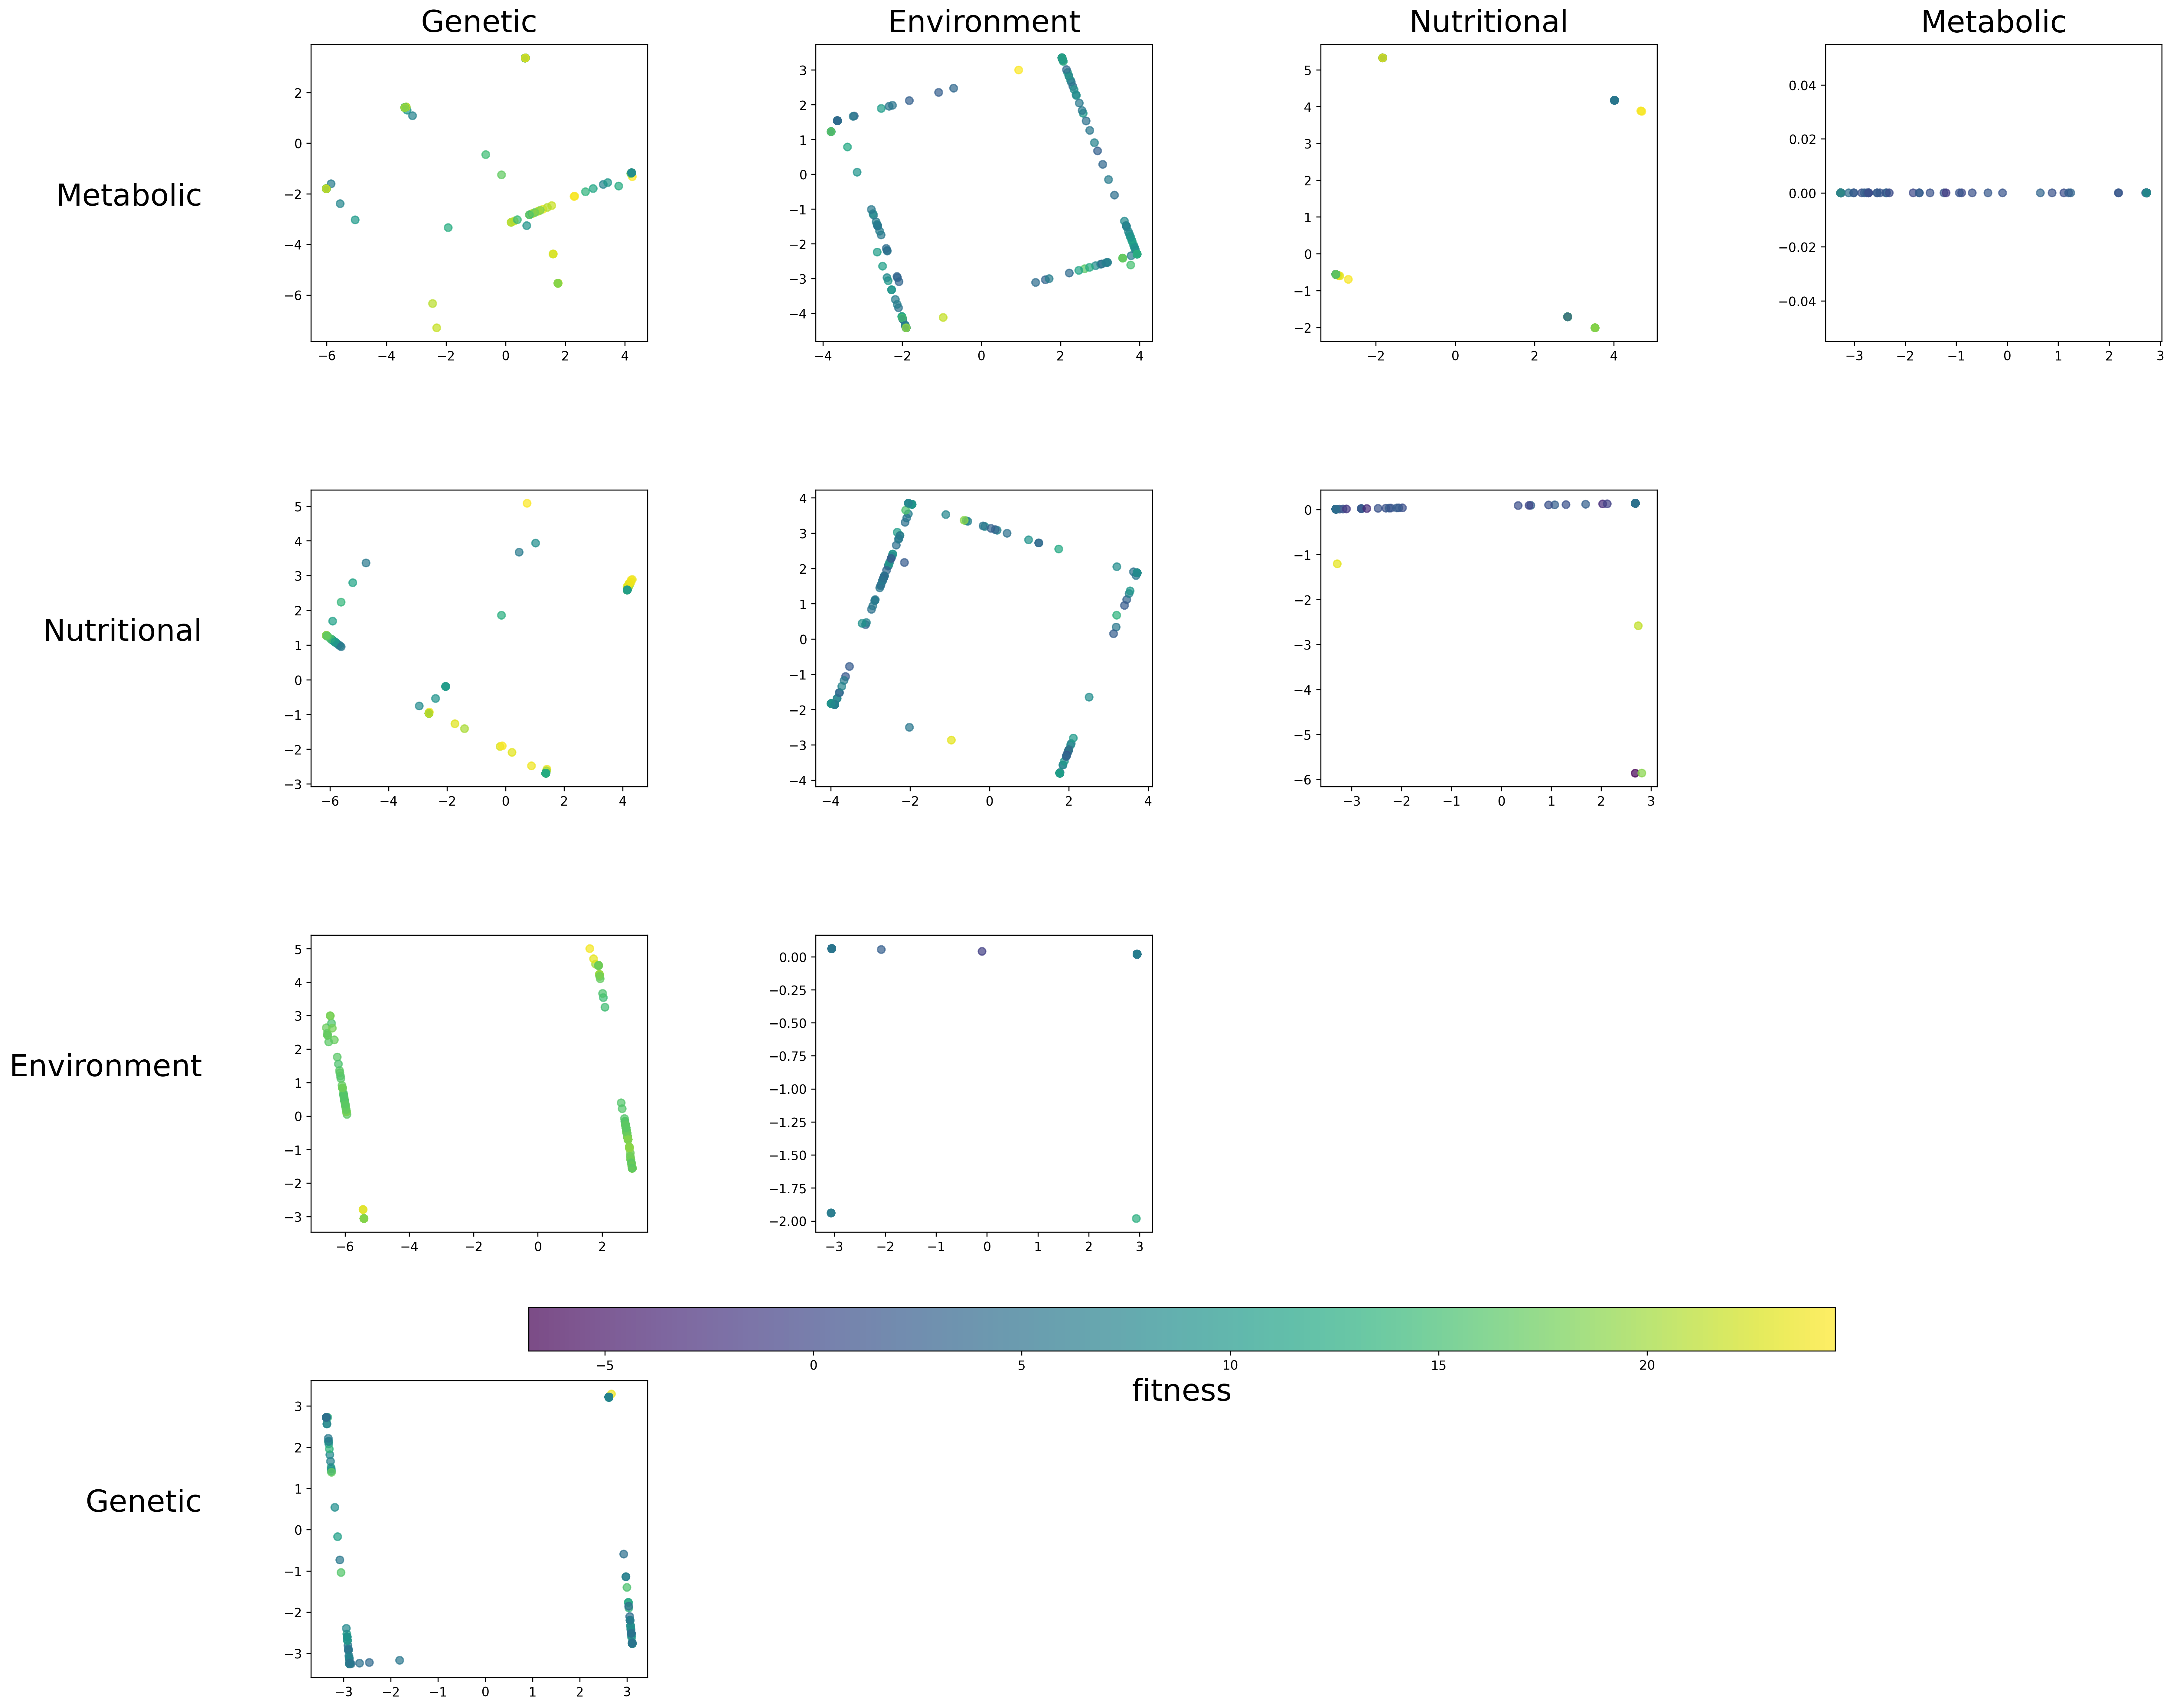

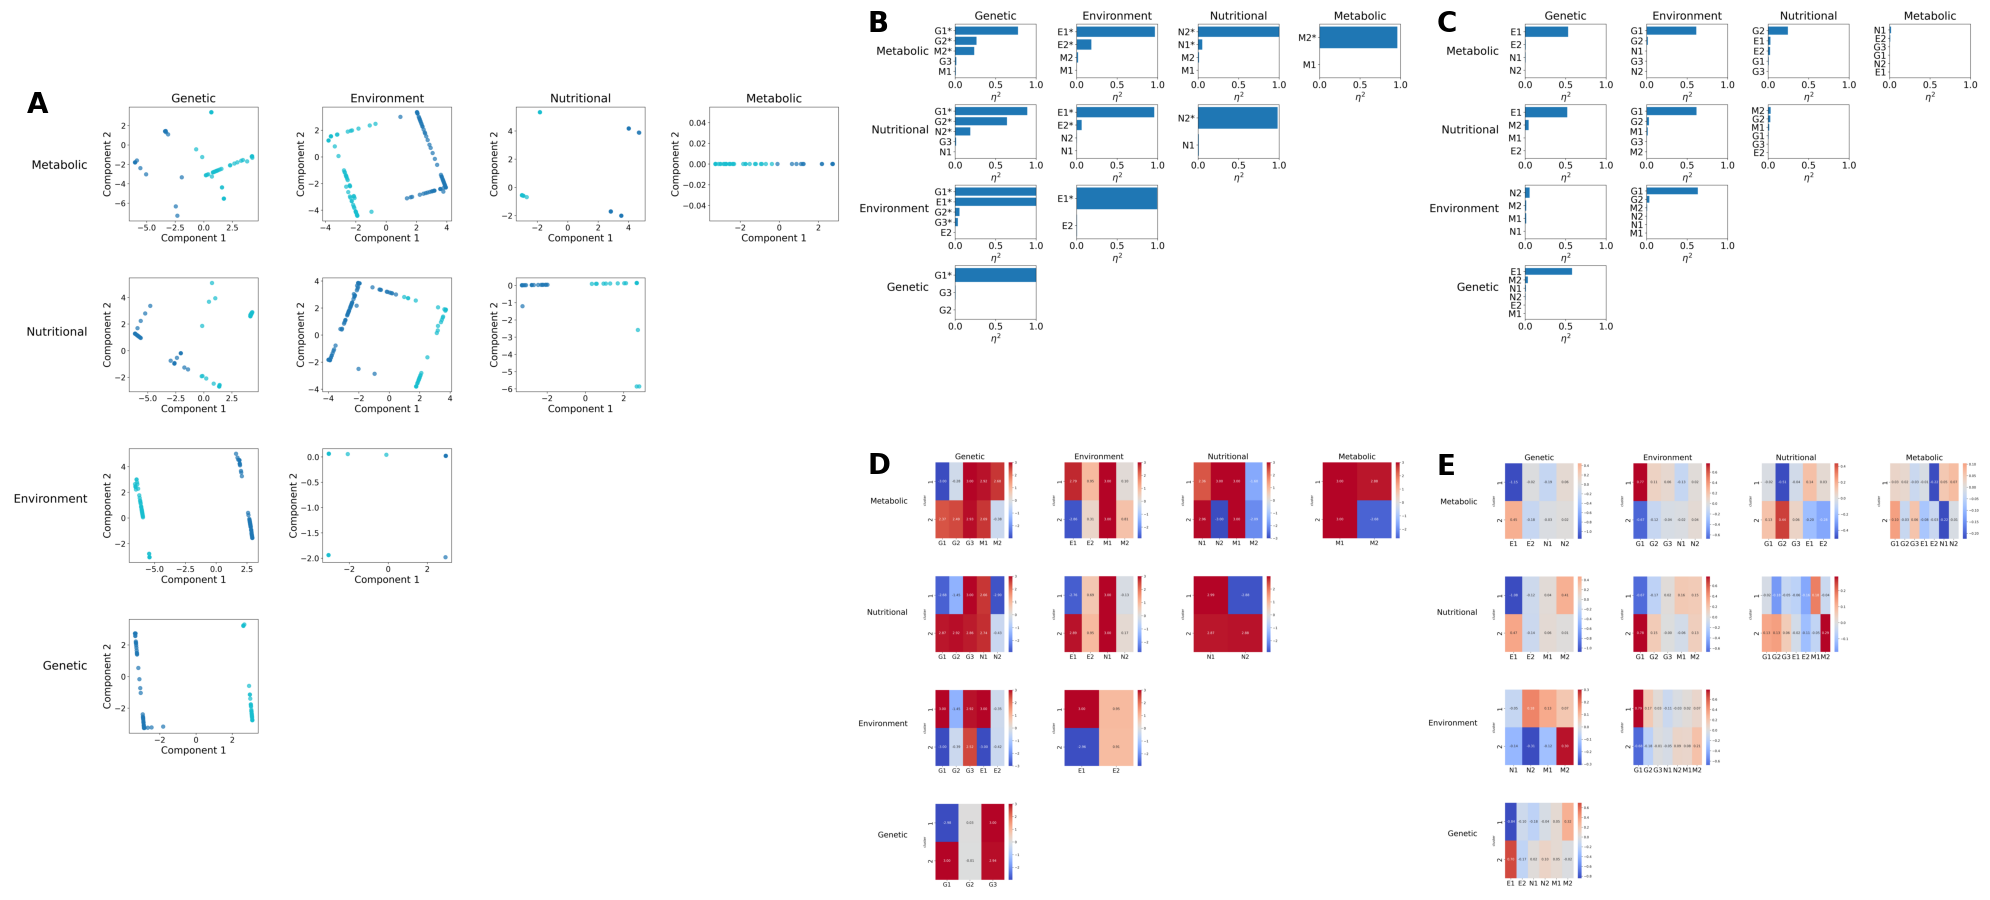

In [21]:
ref_df = pd.read_csv("synthetic/synthetic_test.csv")#.drop(columns="Unnamed: 0")  # Optional reference individuals
color_feature = "PRS_CS.zscr.Shrine.FEV1FVC"  # or "predicted_fitness", or column from ref_df
color_feature = "PregnantCatDog"
color_feature = "fitness"
max_k = 2
cluster_method="kmeans"
reducer=None

# Optional: add ref_df values into archive_data
'''
for key, df in archive_data.items():
    if key < len(ref_df):
        archive_data[key][color_feature] = ref_df.iloc[key][color_feature]
'''
# Compute global vmin/vmax
all_vals = []
for cell_key in cell_feature_sets:
    df = extract_cell_data(archive_data, cell_key)
    if color_feature in df.columns:
        all_vals.extend(df[color_feature].dropna().tolist())

vmin, vmax = min(all_vals), max(all_vals)

fig_ = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_counterfactuals,
    plot_type_name="PCA of Counterfactuals",
    color_feature=color_feature,
    global_vmin=vmin,
    global_vmax=vmax,
    figsize_per_cell=(6, 6),
    colorbar_label=color_feature
)
figA = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_by_cluster,
    plot_type_name="PCA of Counterfactuals",
    #color_feature=color_feature,
    #global_vmin=vmin,
    #global_vmax=vmax,
    figsize_per_cell=(6, 6),
    cluster_method=cluster_method,
    reducer=reducer,
    max_k=max_k,
    legend=True
)
figA.savefig("PCA.png", bbox_inches="tight")

figB = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_eta2_bar_cell,
    plot_type_name="η² for Mutable Features",
    figsize_per_cell=(4, 3),
    cluster_method=cluster_method,
    reducer=reducer,
    max_k=max_k
)
figB.savefig("eta_mutable.png", bbox_inches="tight")


figC = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_eta2_bar_constraints_cell,
    plot_type_name="η² for Constraint Features",
    figsize_per_cell=(4, 3),
    cluster_method=cluster_method,
    reducer=reducer,
    max_k=max_k
)
figC.savefig("eta_constraint.png", bbox_inches="tight")

# Generate and save each grid figure
figD = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_meanvalue_heatmap_cell,
    plot_type_name="Mutable",
    figsize_per_cell=(6, 6),
    cluster_method=cluster_method,
    reducer=reducer,
    max_k=max_k
)
figD.savefig("grid_mutable.png", bbox_inches="tight")

figE = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_meanvalue_heatmap_constraints_cell,
    plot_type_name="Constraint",
    figsize_per_cell=(6, 6),
    cluster_method=cluster_method,
    reducer=reducer,
    max_k=max_k
)
figE.savefig("grid_constraint.png", bbox_inches="tight")

plt.close(figA)
plt.close(figB)
plt.close(figD)
plt.close(figC)
plt.close(figE)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import numpy as np

# Load images
imgA = np.array(Image.open("PCA.png"))
img1 = np.array(Image.open("eta_mutable.png"))
img2 = np.array(Image.open("eta_constraint.png"))
img3 = np.array(Image.open("grid_mutable.png"))
img4 = np.array(Image.open("grid_constraint.png"))

# Create figure and grid layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, figure=fig, width_ratios=[1.5, 1, 1])  # <-- Make A wider

# Big PCA plot on the left (A)
axA = fig.add_subplot(gs[:, 0])
axA.imshow(imgA)
axA.axis('off')
axA.text(0.02, 1, "A", transform=axA.transAxes, fontsize=20, fontweight='bold', va='top')
axA.set_xlabel("PC1", fontsize=14)
axA.set_ylabel("PC2", fontsize=14)

# Small plots on the right (B–E)
axB = fig.add_subplot(gs[0, 1])
axB.imshow(img1)
axB.axis('off')
axB.text(0.02, 1, "B", transform=axB.transAxes, fontsize=20, fontweight='bold', va='top')

axC = fig.add_subplot(gs[0, 2])
axC.imshow(img2)
axC.axis('off')
axC.text(0.02, 1, "C", transform=axC.transAxes, fontsize=20, fontweight='bold', va='top')

axD = fig.add_subplot(gs[1, 1])
axD.imshow(img3)
axD.axis('off')
axD.text(0.02, 1, "D", transform=axD.transAxes, fontsize=20, fontweight='bold', va='top')

axE = fig.add_subplot(gs[1, 2])
axE.imshow(img4)
axE.axis('off')
axE.text(0.02, 1, "E", transform=axE.transAxes, fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.show()


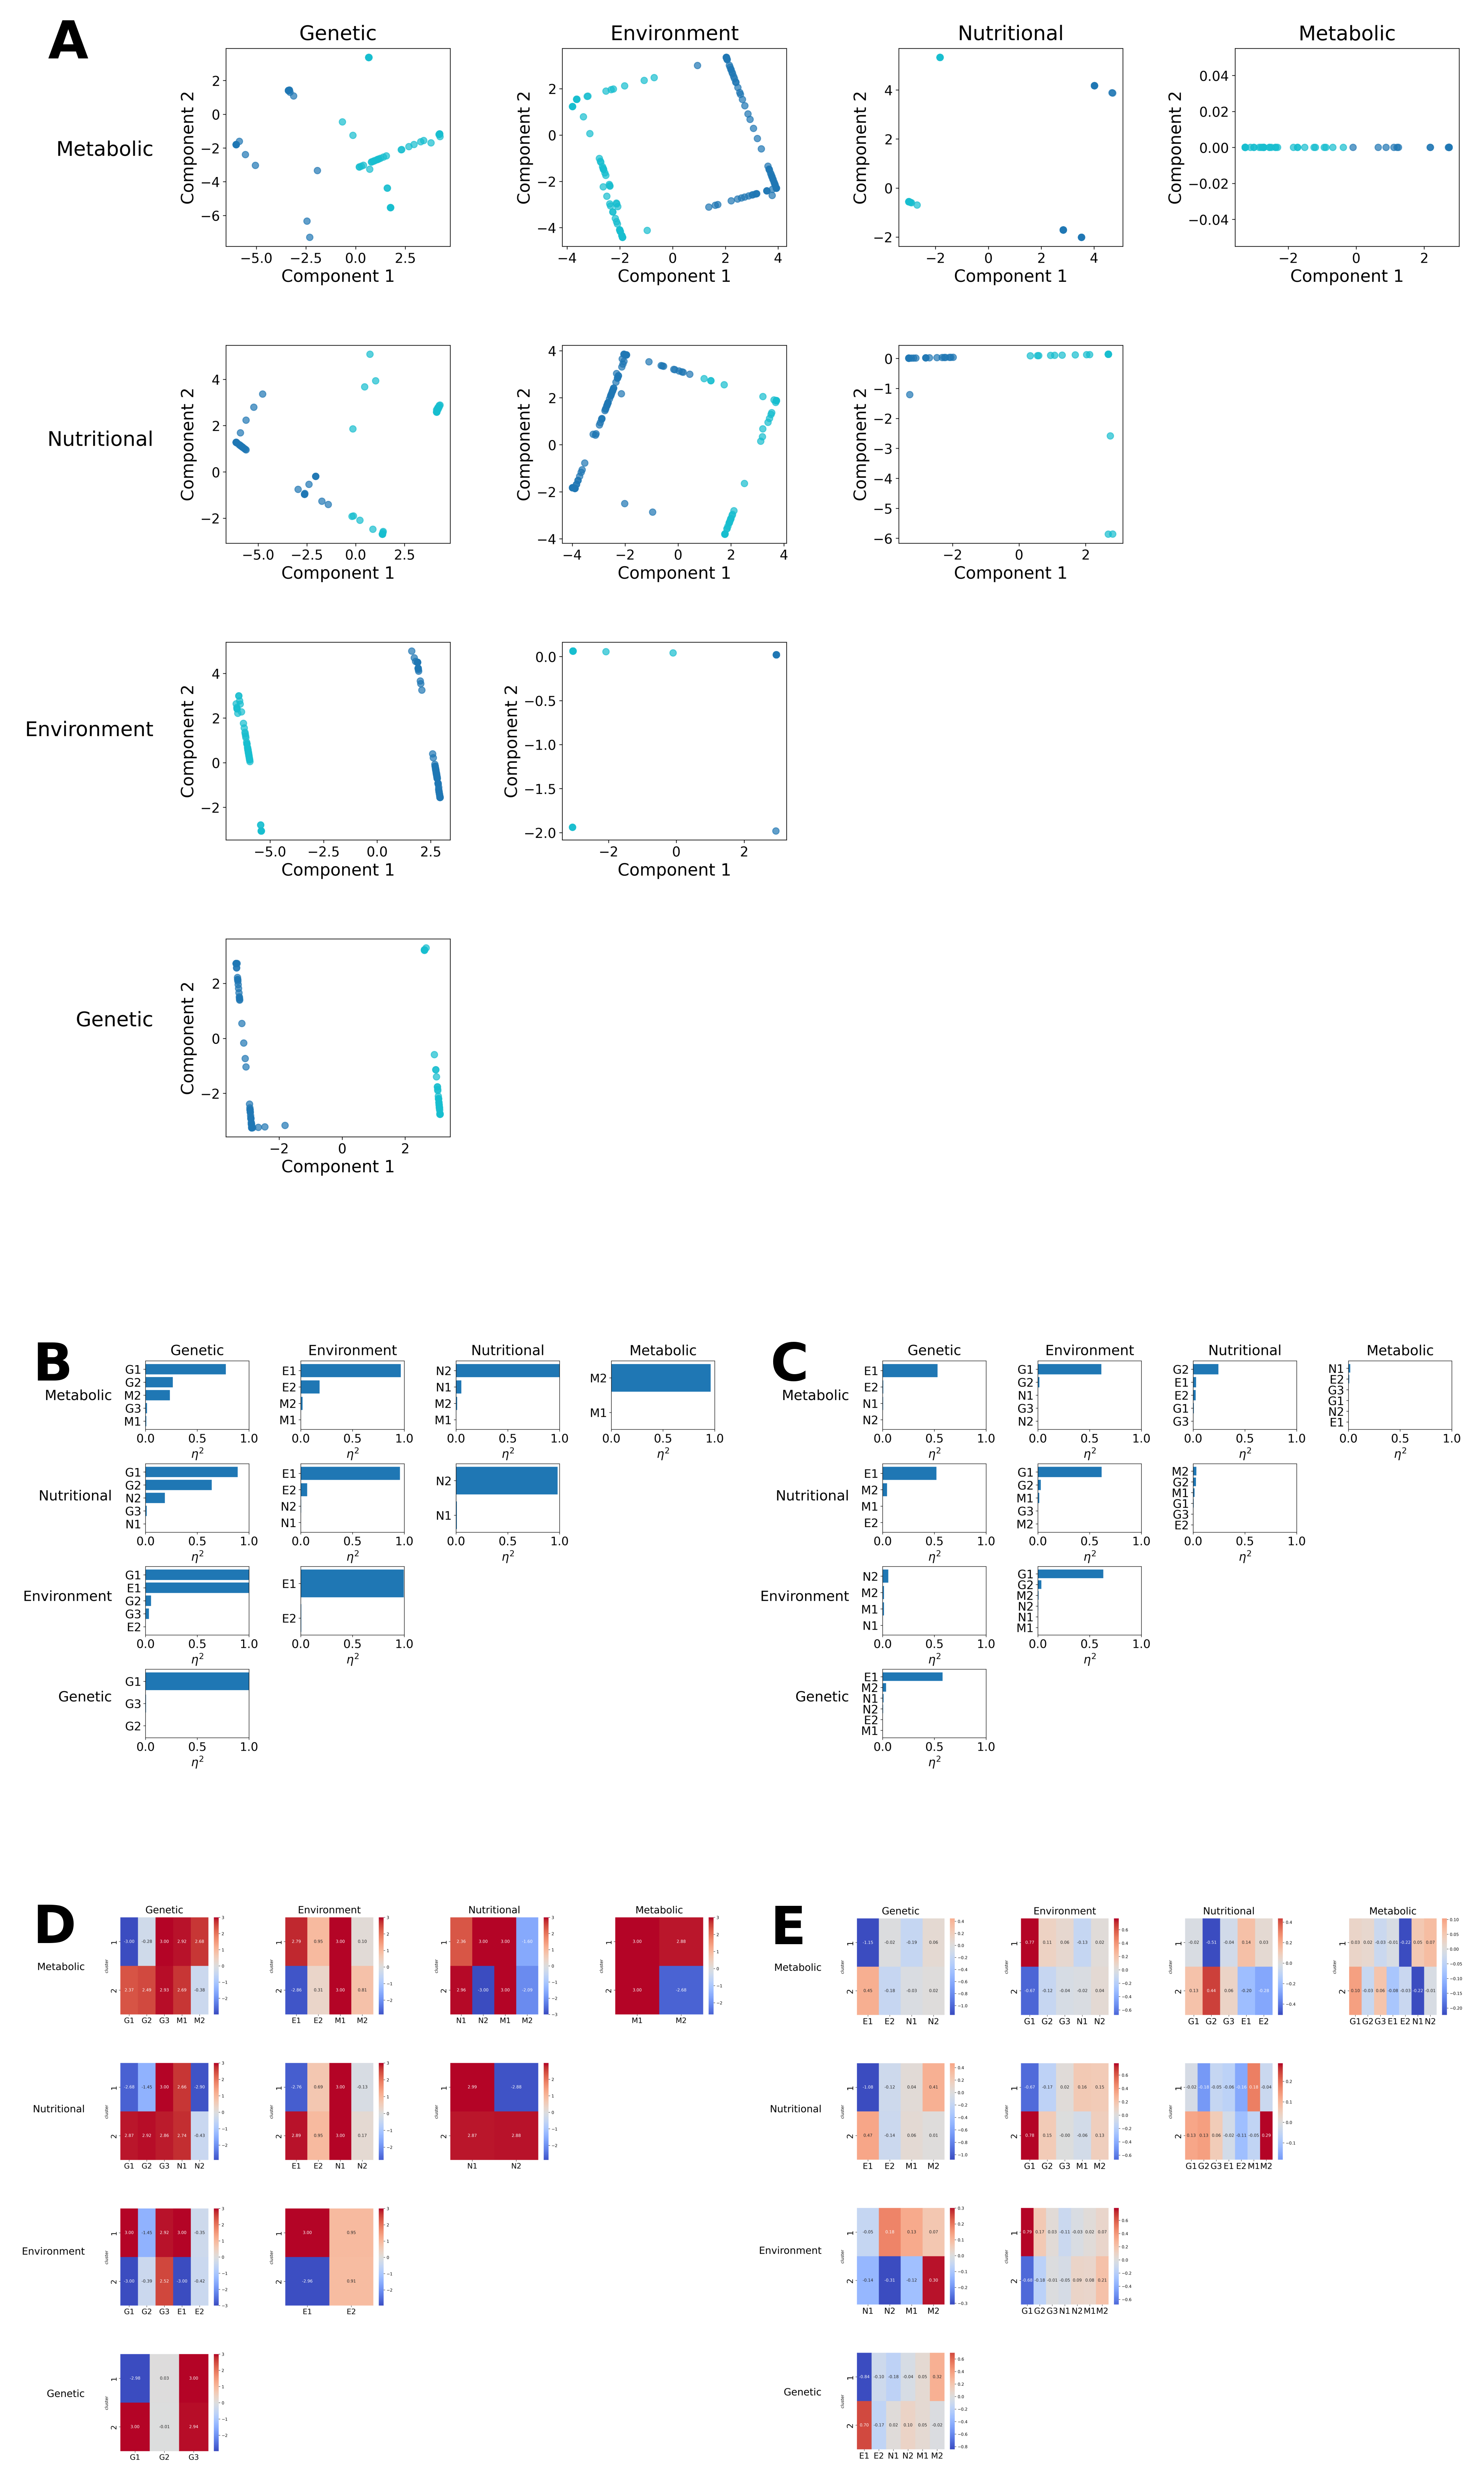

: 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 14), dpi=500)

# 3 rows: A (top row), B–E (2×2 grid below)
gs = GridSpec(3, 2, figure=fig, height_ratios=[2, 1, 1])  # A gets more height

# Plot A on top, spanning both columns
axA = fig.add_subplot(gs[0, :])
axA.imshow(imgA)
axA.axis('off')
axA.text(0.02, 1, "A", transform=axA.transAxes, fontsize=20, fontweight='bold', va='top')
axA.set_xlabel("PC1", fontsize=14)
axA.set_ylabel("PC2", fontsize=14)

# Plots B–E in a 2x2 grid below A
axB = fig.add_subplot(gs[1, 0])
axB.imshow(img1)
axB.axis('off')
axB.text(0.02, 1, "B", transform=axB.transAxes, fontsize=20, fontweight='bold', va='top')

axC = fig.add_subplot(gs[1, 1])
axC.imshow(img2)
axC.axis('off')
axC.text(0.02, 1, "C", transform=axC.transAxes, fontsize=20, fontweight='bold', va='top')

axD = fig.add_subplot(gs[2, 0])
axD.imshow(img3)
axD.axis('off')
axD.text(0.02, 1, "D", transform=axD.transAxes, fontsize=20, fontweight='bold', va='top')

axE = fig.add_subplot(gs[2, 1])
axE.imshow(img4)
axE.axis('off')
axE.text(0.02, 1, "E", transform=axE.transAxes, fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.show()


#### Decision trees

In [19]:
fig_ = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    tree_constraints_to_cluster_kmeans,
    plot_type_name="PCA of Counterfactuals",
    figsize_per_cell=(10, 7),
    hspace=0.1,
    wspace=0.1,
    max_k=2,
    max_depth=3
 
)

#### UMAP

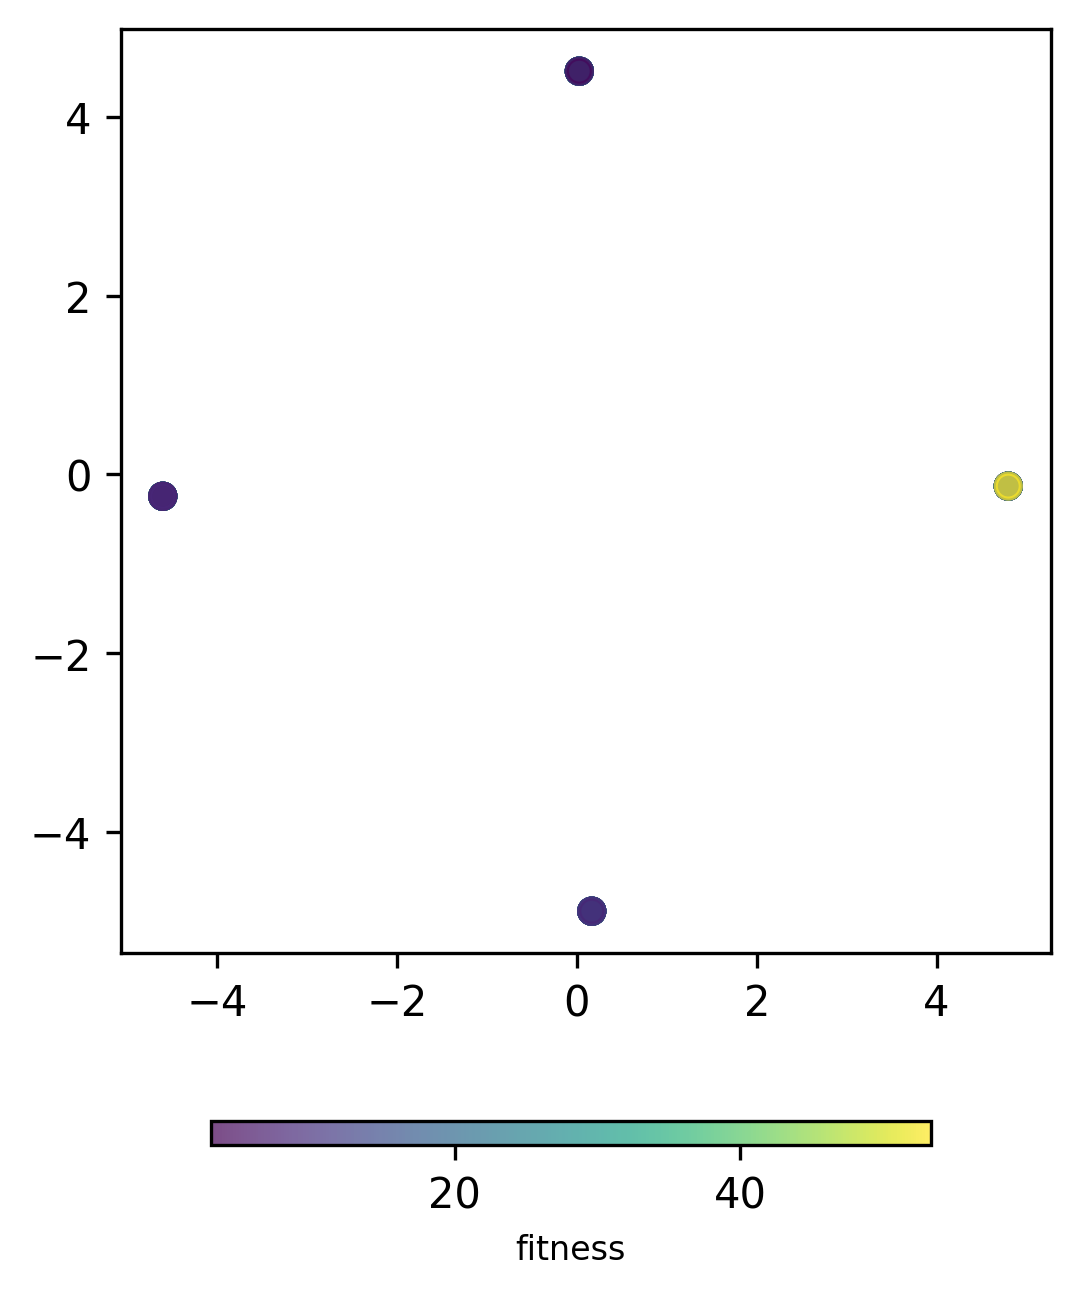

In [127]:
ref_df = pd.read_csv("synthetic/synthetic_test.csv").drop(columns="Unnamed: 0")  # Optional reference individuals
color_feature = "PRS_CS.zscr.Shrine.FEV1FVC"  # or "predicted_fitness", or column from ref_df
color_feature = "PregnantCatDog"
color_feature = "fitness"

# Optional: add ref_df values into archive_data
'''
for key, df in archive_data.items():
    if key < len(ref_df):
        archive_data[key][color_feature] = ref_df.iloc[key][color_feature]
'''
# Compute global vmin/vmax
all_vals = []
for cell_key in cell_feature_sets:
    df = extract_cell_data(archive_data, cell_key)
    if color_feature in df.columns:
        all_vals.extend(df[color_feature].dropna().tolist())

vmin, vmax = min(all_vals), max(all_vals)

fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_single_pca,
    plot_type_name="PCA of Counterfactuals",
    color_feature=color_feature,
    global_vmin=vmin,
    global_vmax=vmax,
    figsize_per_cell=(4, 4),
    colorbar_label=color_feature
)
plt.show()





#### Eta bar plots

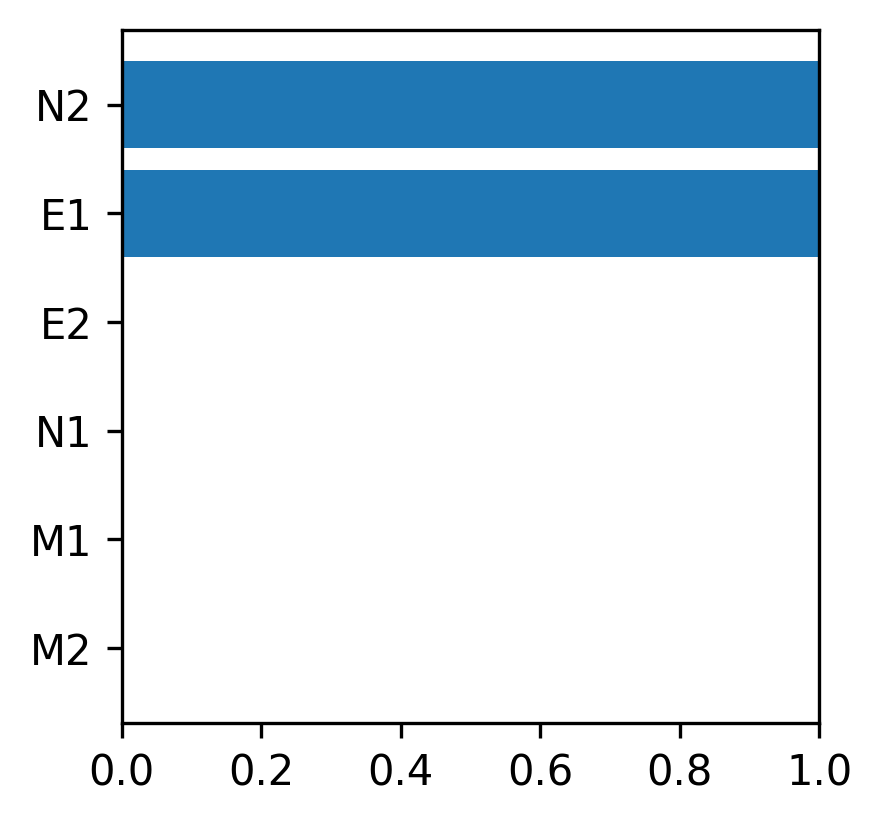

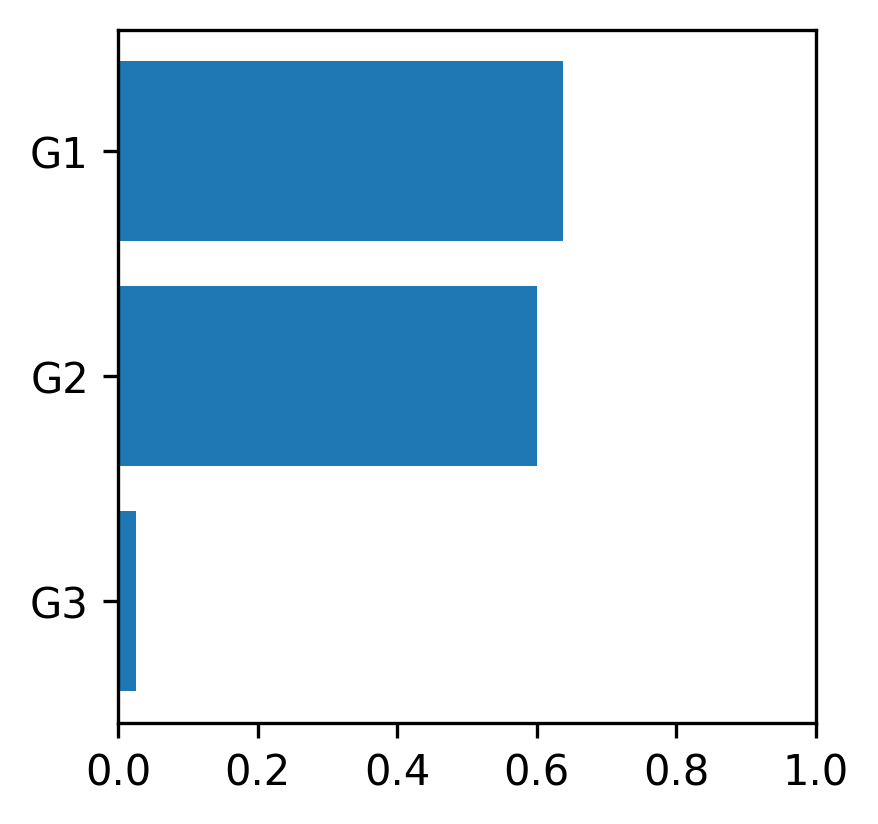

In [119]:
fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_eta2_bar_cell,
    plot_type_name="η² for Mutable Features",
    figsize_per_cell=(3, 3)
)
plt.show()

fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_eta2_bar_constraints_cell,
    plot_type_name="η² for Constraint Features",
    figsize_per_cell=(3, 3)
)
plt.show()


#### Heatmap of means

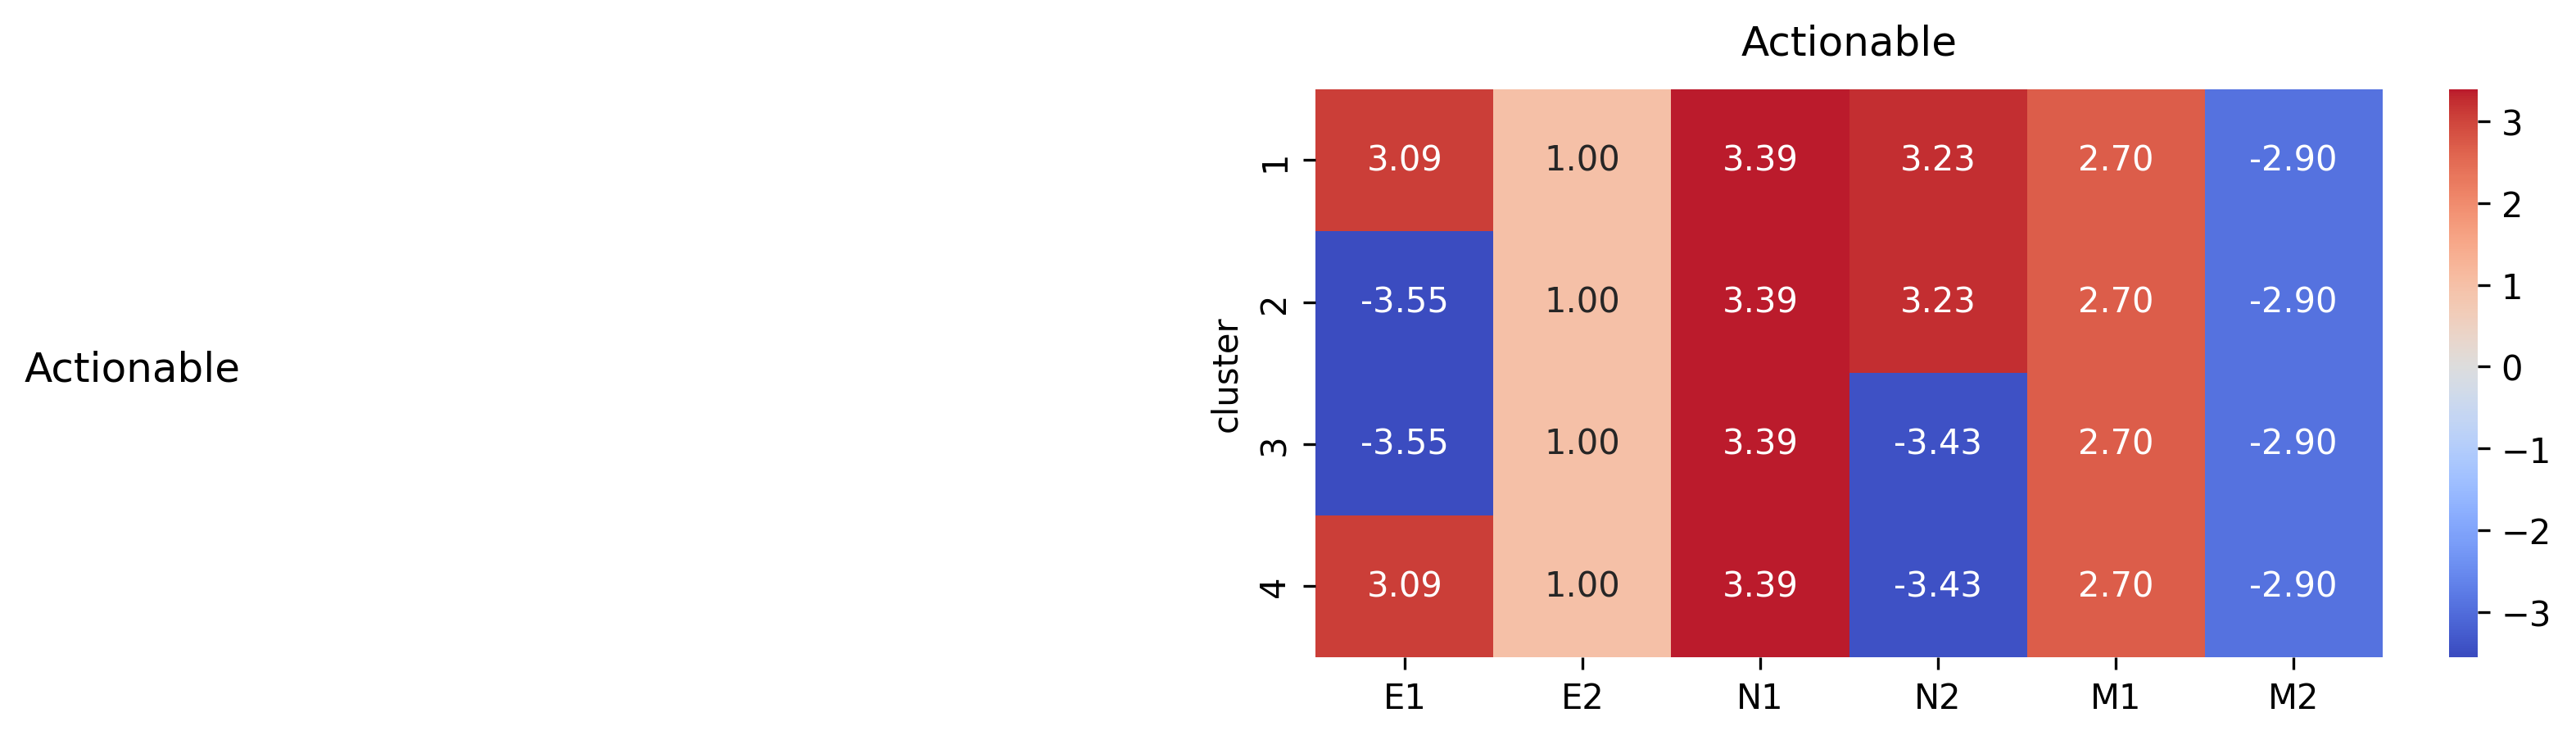

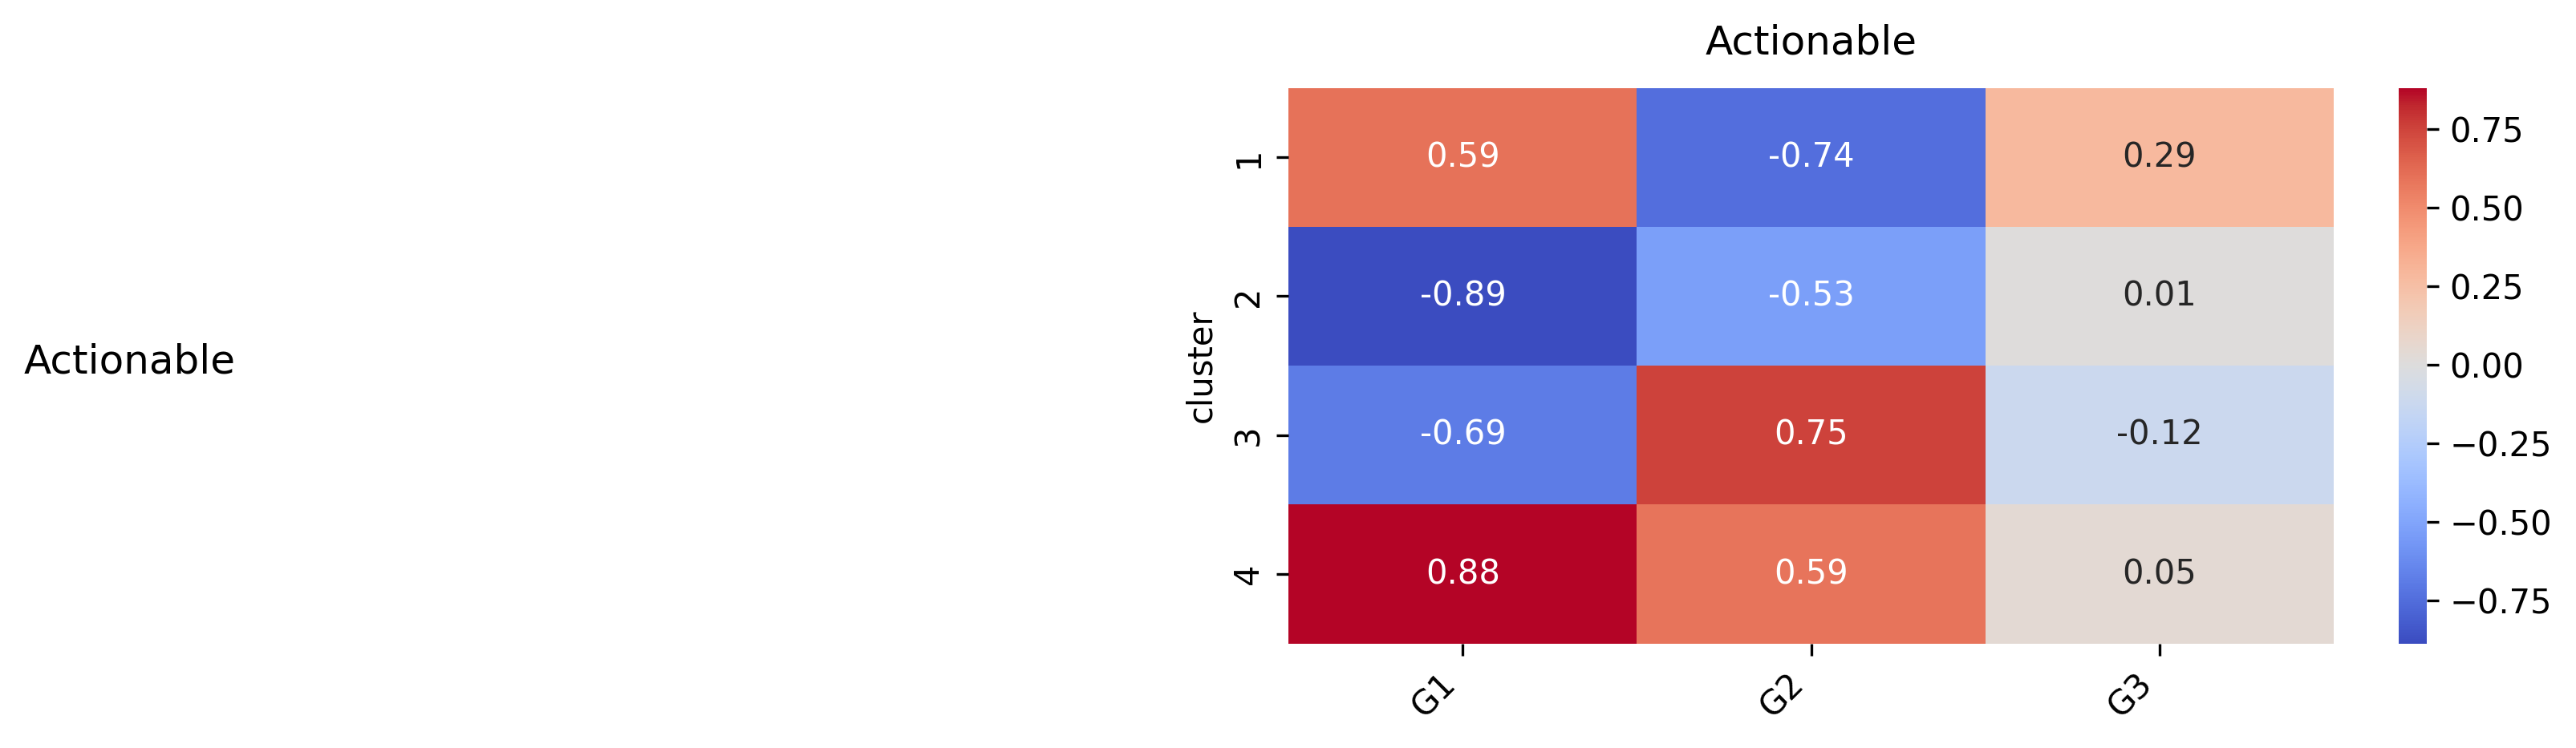

In [6]:
fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_meanvalue_heatmap_cell,
    plot_type_name="Mean Values per Cluster (Mutable)",  # or any other number of clusters you'd like to use
    figsize_per_cell=(7, 3)
)
plt.show()


fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_meanvalue_heatmap_constraints_cell,
    plot_type_name="Mean Values per Cluster (Constraint)",
    figsize_per_cell=(7, 3)
)
plt.show()


#### KDE plots

/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args

[Cell (0, 0)] Error: not enough values to unpack (expected 3, got 2)


/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *arg

[Cell (0, 1)] Error: not enough values to unpack (expected 3, got 2)
[Cell (0, 2)] Error: not enough values to unpack (expected 3, got 2)
[Cell (0, 3)] Error: not enough values to unpack (expected 3, got 2)


/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args

[Cell (1, 1)] Error: not enough values to unpack (expected 3, got 2)
[Cell (1, 2)] Error: not enough values to unpack (expected 3, got 2)


/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *arg

[Cell (1, 3)] Error: not enough values to unpack (expected 3, got 2)


/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args

[Cell (2, 2)] Error: not enough values to unpack (expected 3, got 2)
[Cell (2, 3)] Error: not enough values to unpack (expected 3, got 2)


/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/global/home/hpc5434/.local/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *arg

[Cell (3, 3)] Error: not enough values to unpack (expected 3, got 2)


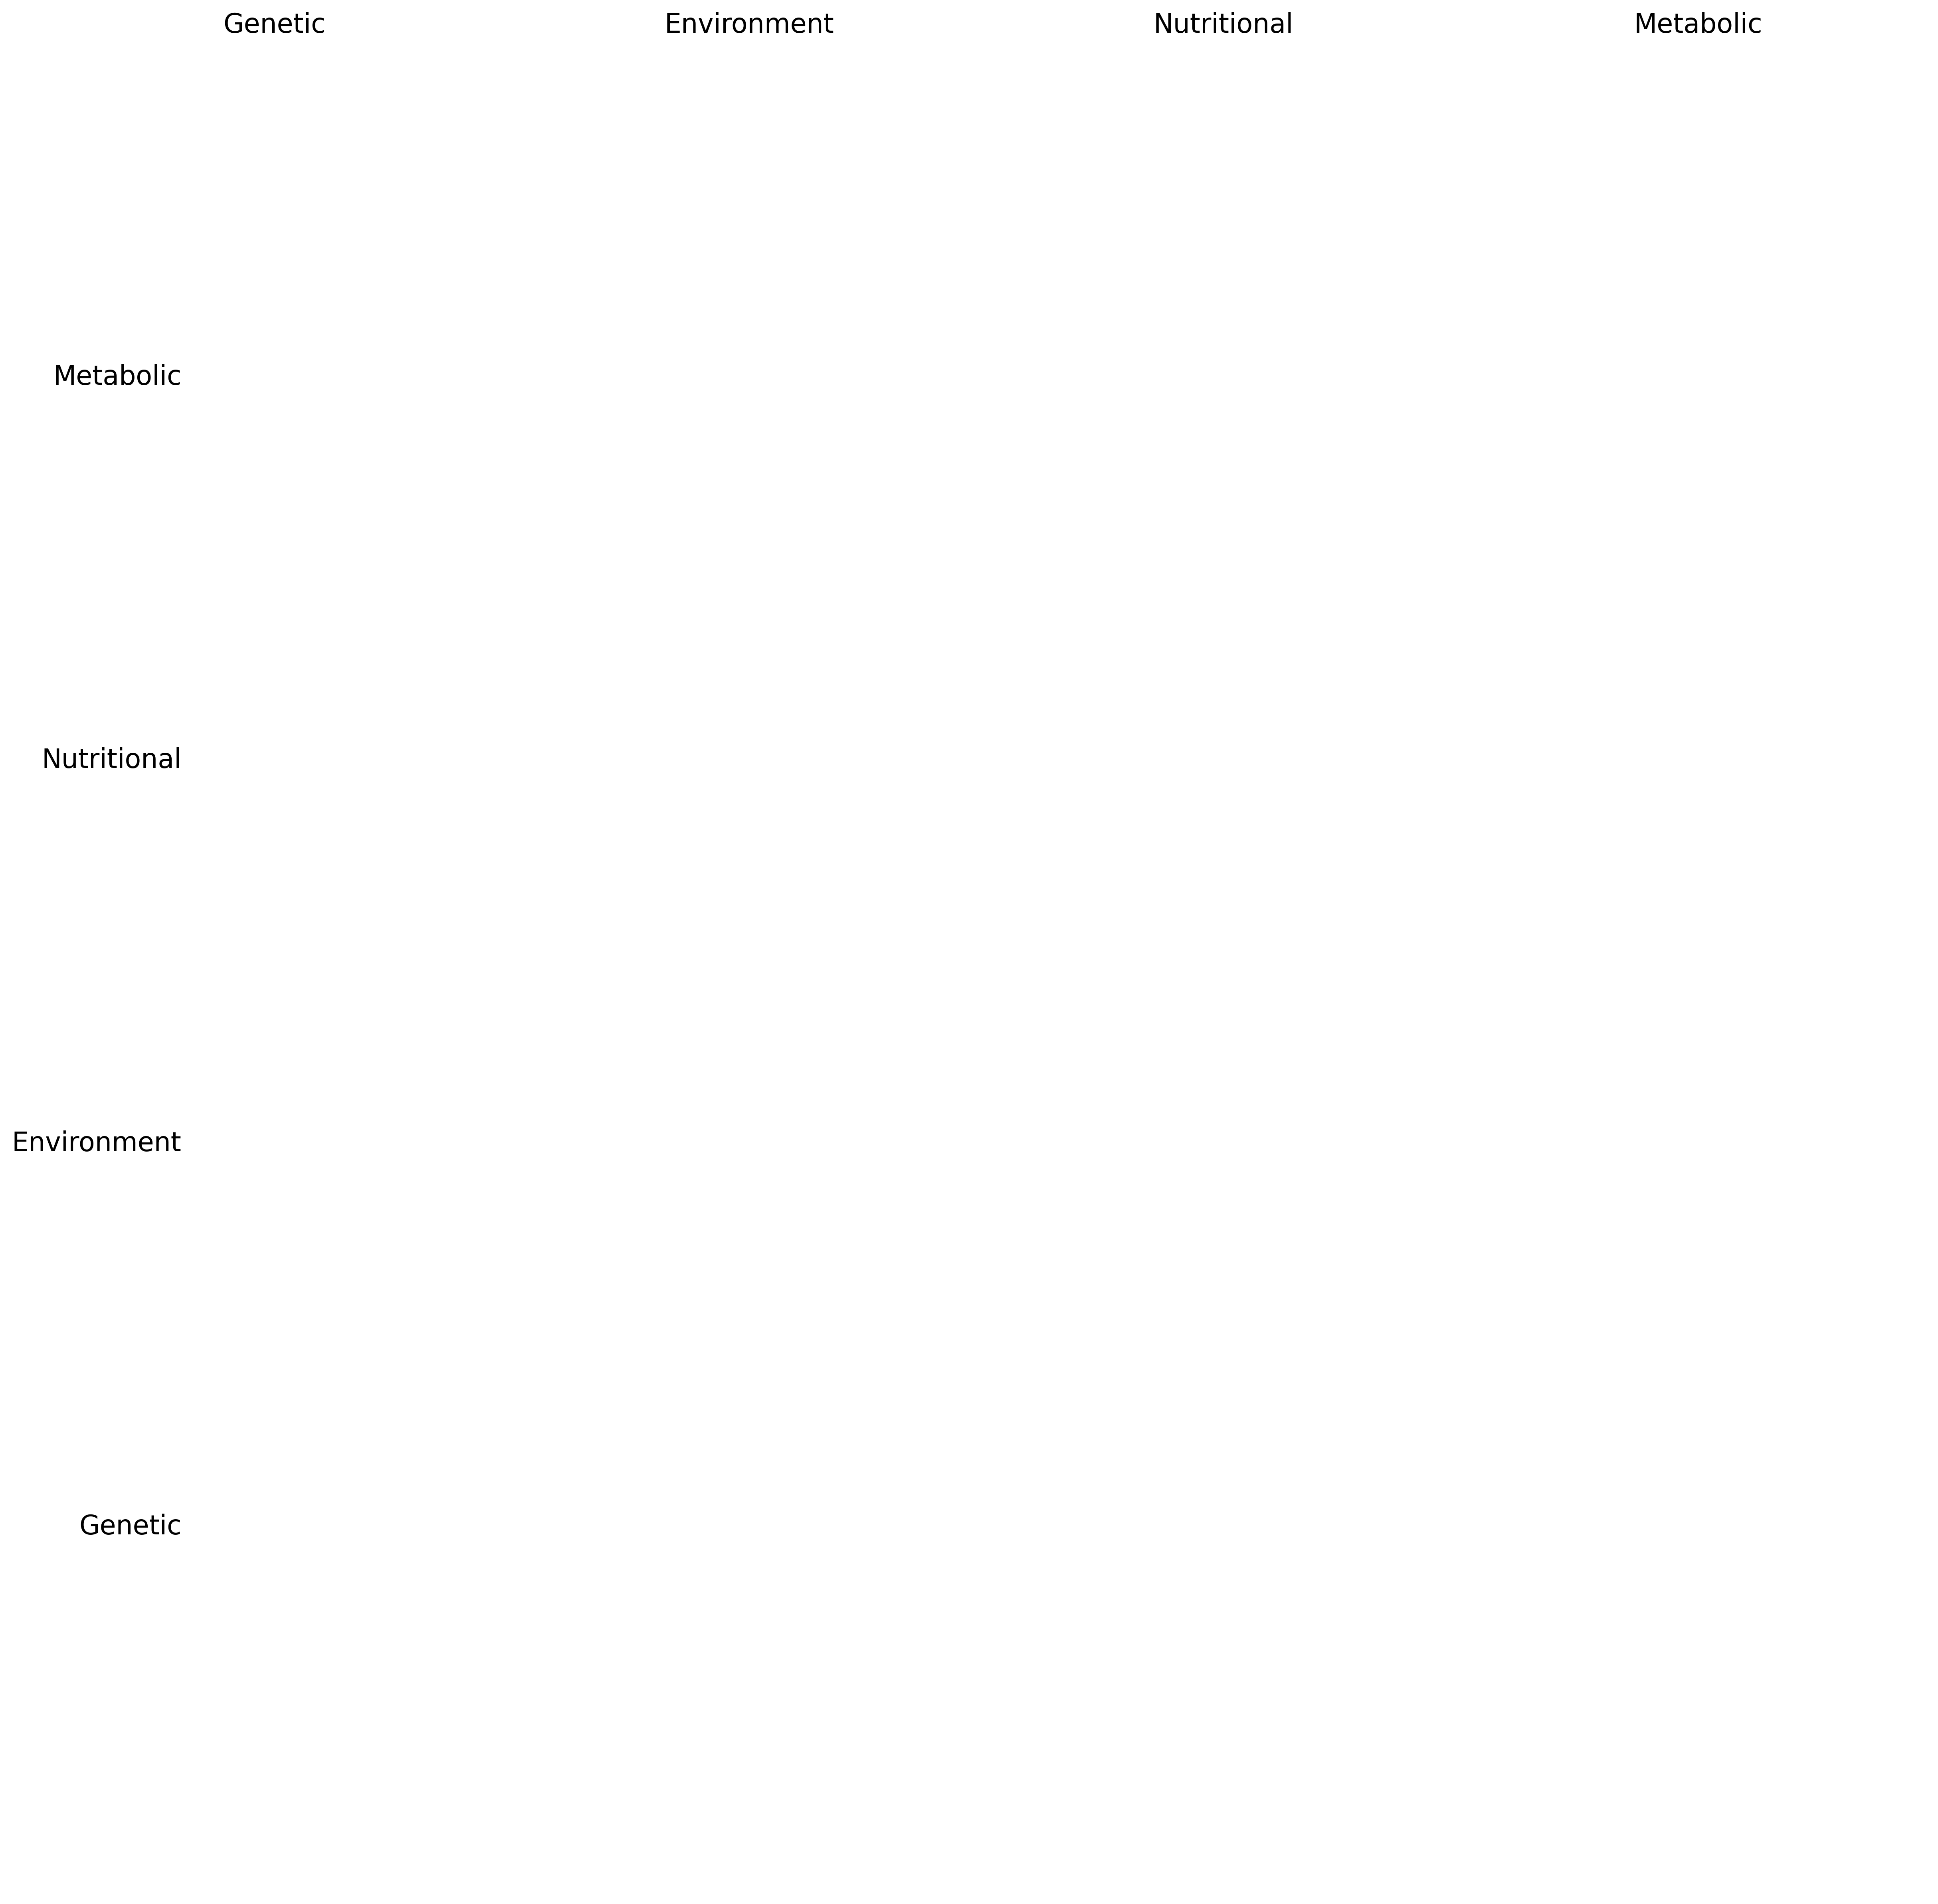

In [45]:
feature_to_plot = "N2"

fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    plot_cf_kde_cell,
    plot_type_name=f"KDE of {feature_to_plot}",
    feature=feature_to_plot,
    max_k=10
)
plt.tight_layout()
plt.show()



In [46]:
print(plot_cf_kde_cell.__code__.co_varnames)


('ax', 'df', 'cell_key', 'mutable_features', 'feature', 'max_k', 'min_variance', 'X', 'scaler', 'X_scaled', 'k', 'labels', 'Z', 'plotted', 'c', 'cluster_values', 'e')


Y max after plotting: 5.0


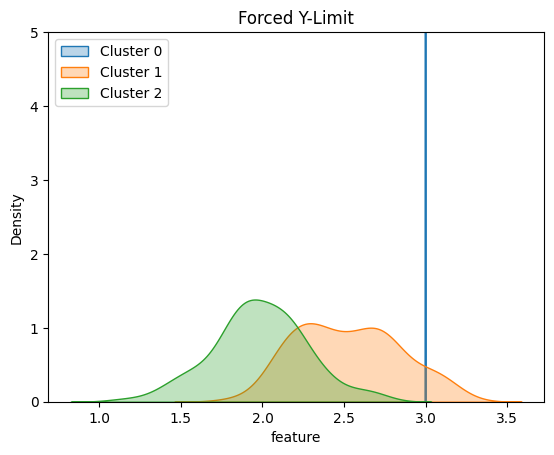

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Fake clustered data
np.random.seed(0)
cluster_data = {
    'cluster': [0]*100 + [1]*100 + [2]*100,
    'feature': (
        np.random.normal(3.0, 0.001, 100).tolist() +  # Narrow spike
        np.random.normal(2.5, 0.3, 100).tolist() +    # Wide bump
        np.random.normal(2.0, 0.3, 100).tolist()      # Wide bump
    )
}
df = pd.DataFrame(cluster_data)

# Plotting
fig, ax = plt.subplots()

for c in df['cluster'].unique():
    subset = df[df['cluster'] == c]['feature']
    sns.kdeplot(subset, label=f'Cluster {c}', fill=True, ax=ax, alpha=0.3, common_norm=False)

ax.set_ylim(0, 5)  # ✅ force y-axis limit
ax.set_title("Forced Y-Limit")
print("Y max after plotting:", ax.get_ylim()[1])
ax.legend()
plt.show()


[ERROR] Cell (0, 0) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (0, 1) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (0, 2) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (0, 3) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (1, 1) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (1, 2) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (1, 3) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (2, 2) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (2, 3) → optimal_clusters() got an unexpected keyword argument 'max_clusters'
[ERROR] Cell (3, 3) → optimal_clusters() got an unexpected keyword argument 'max_clusters'


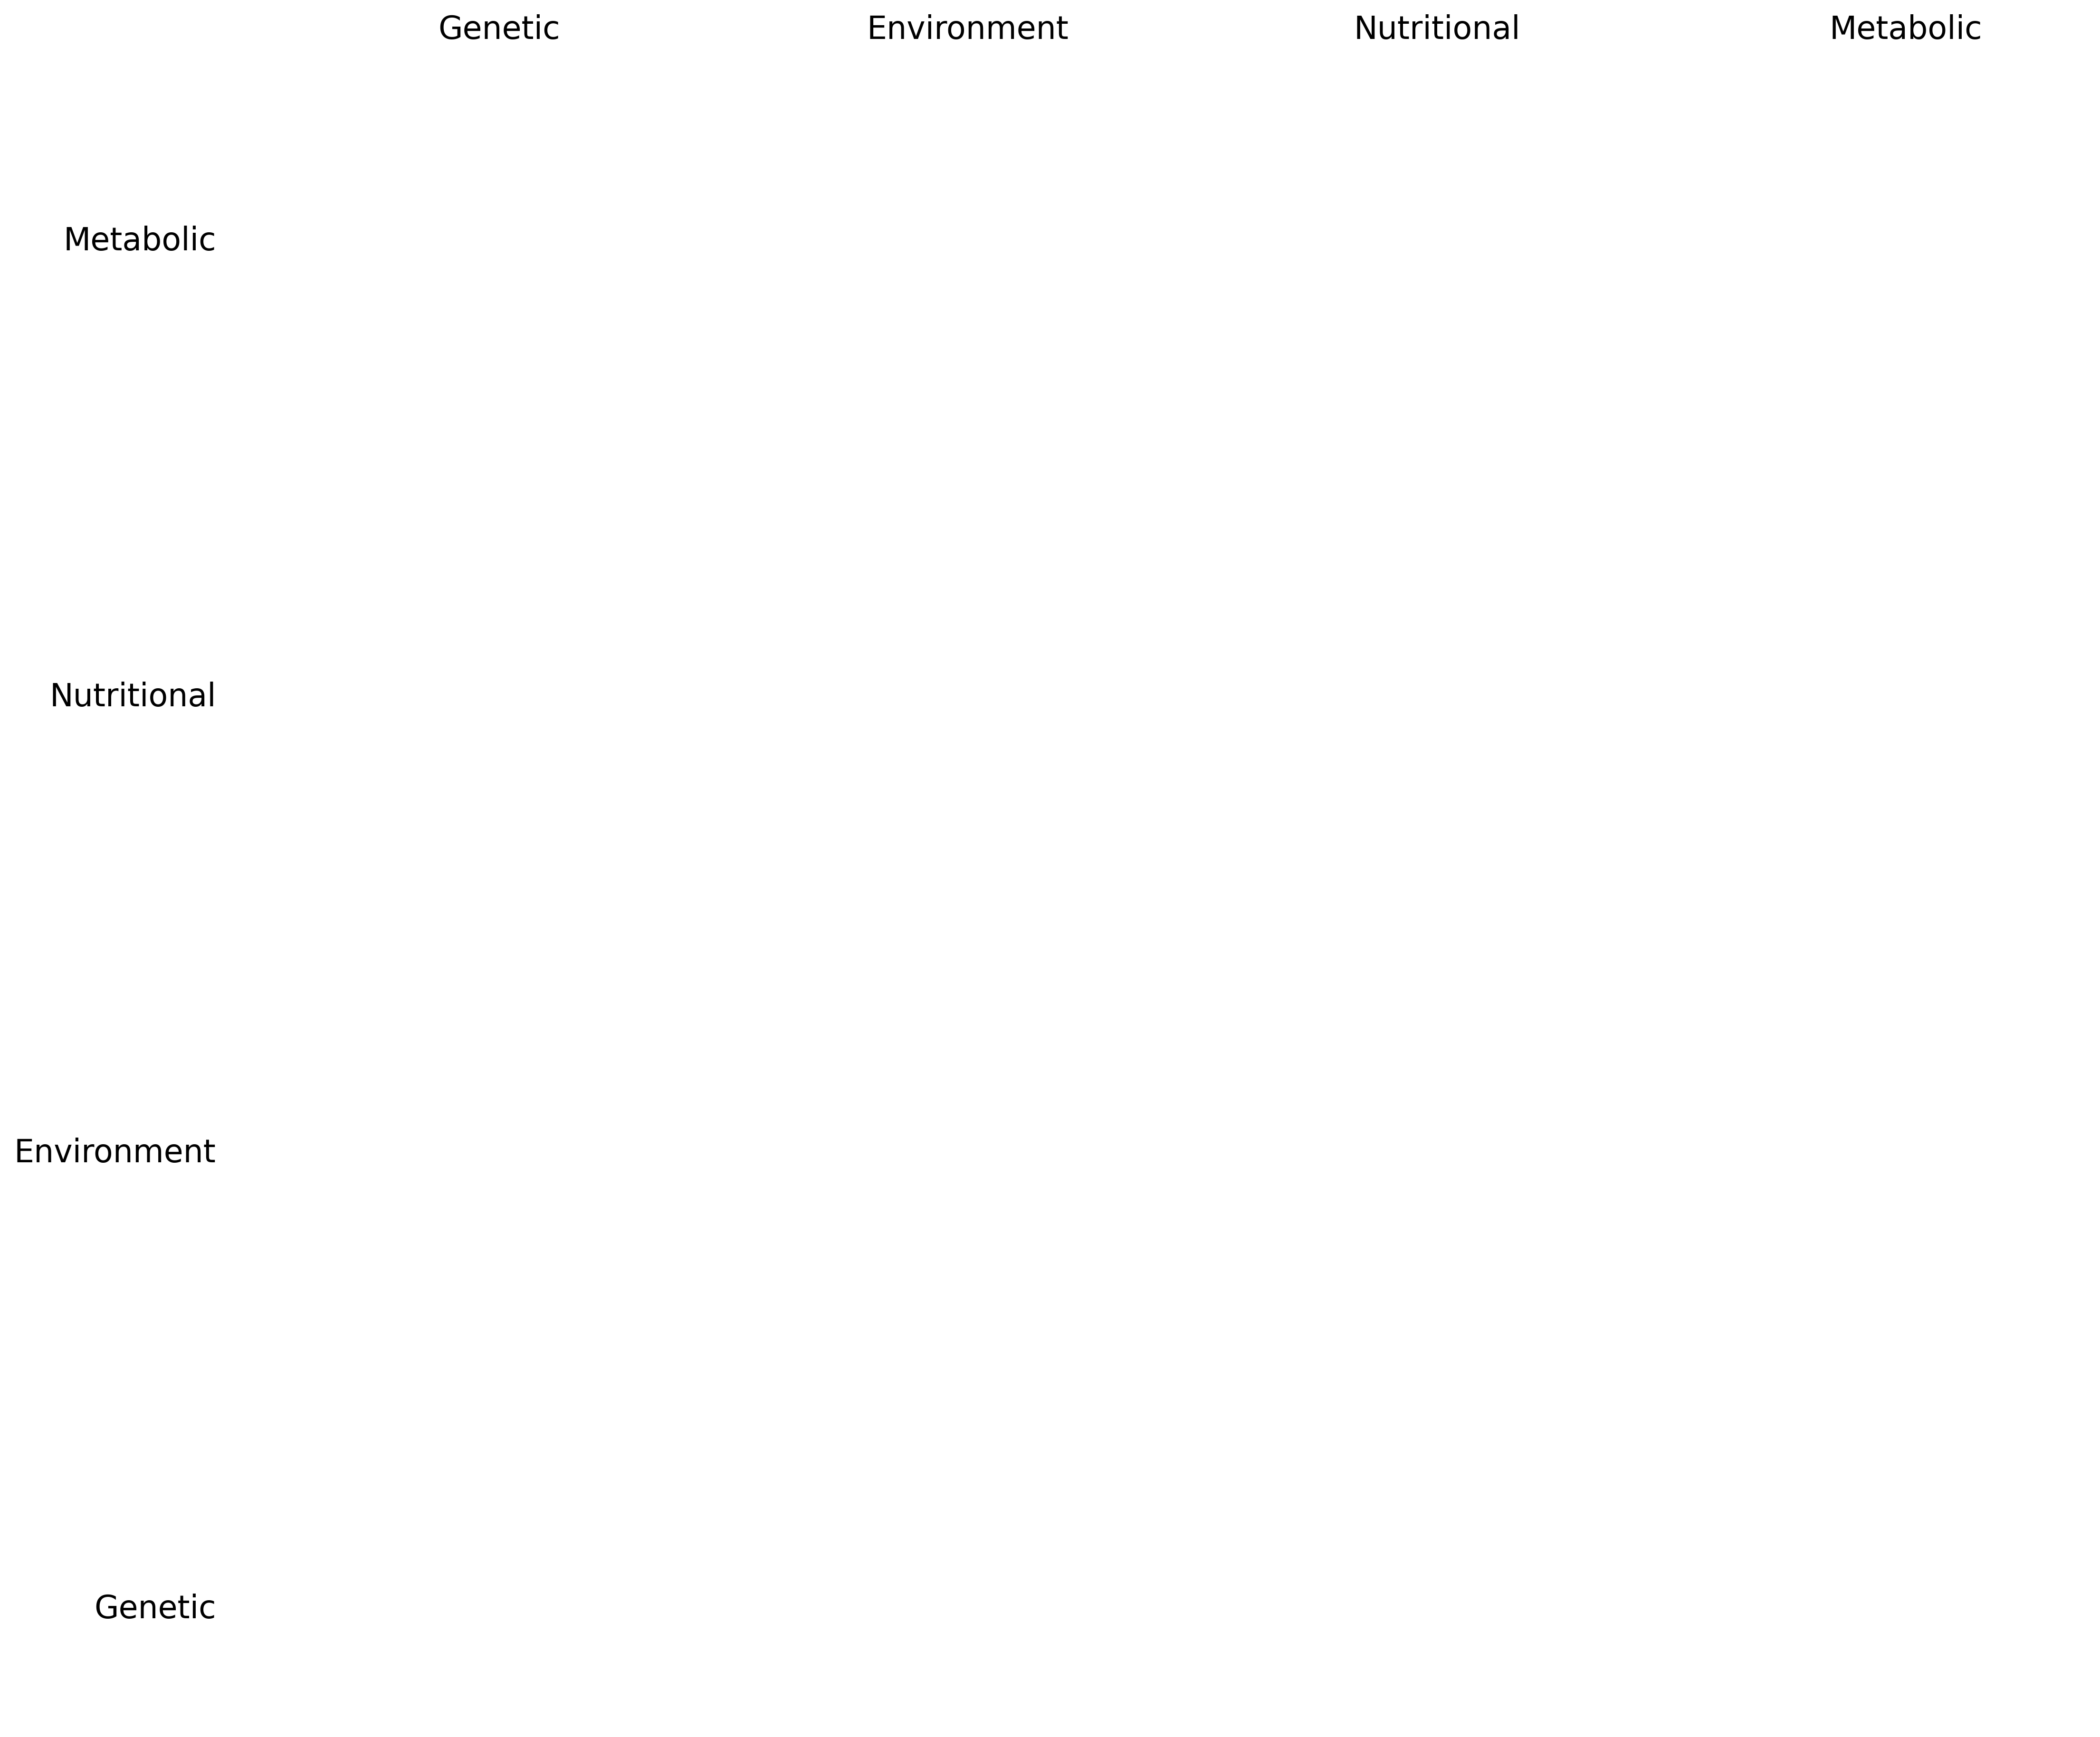

In [48]:
fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    tree_constraints_to_cluster_cell_pca_kmeans,
    plot_type_name="Decision Trees (Constraints → Cluster)"
)
plt.show()


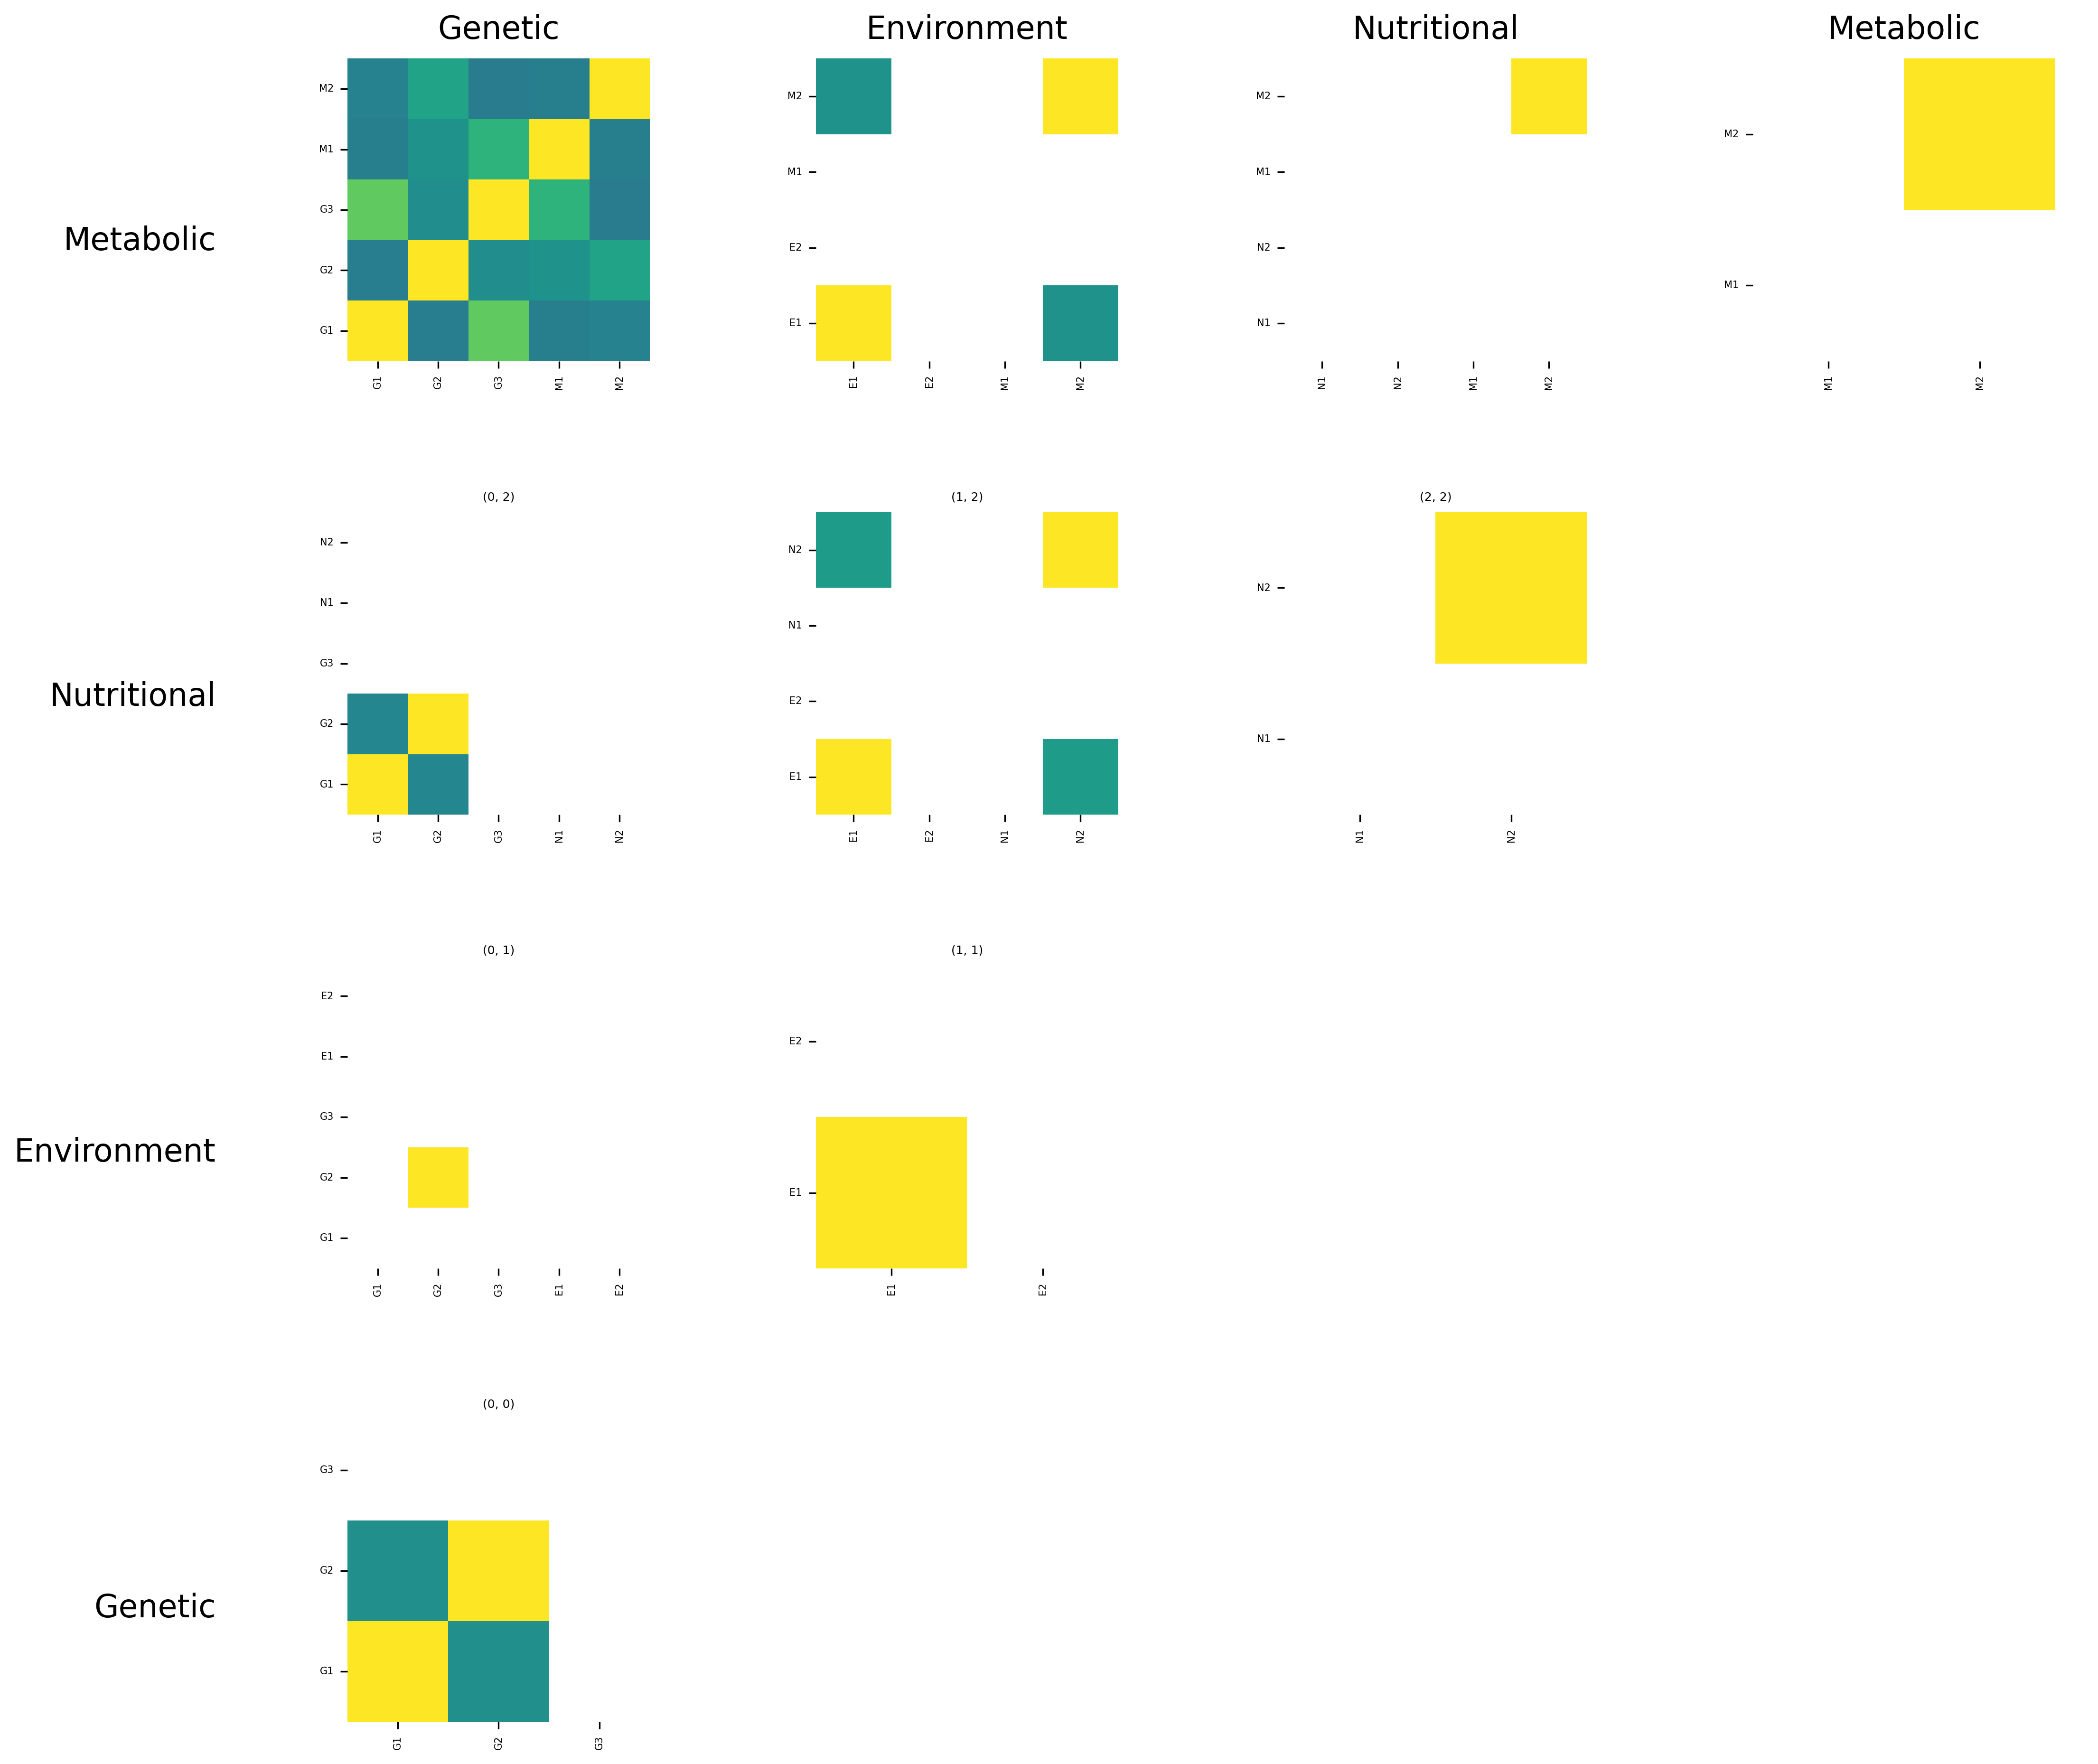

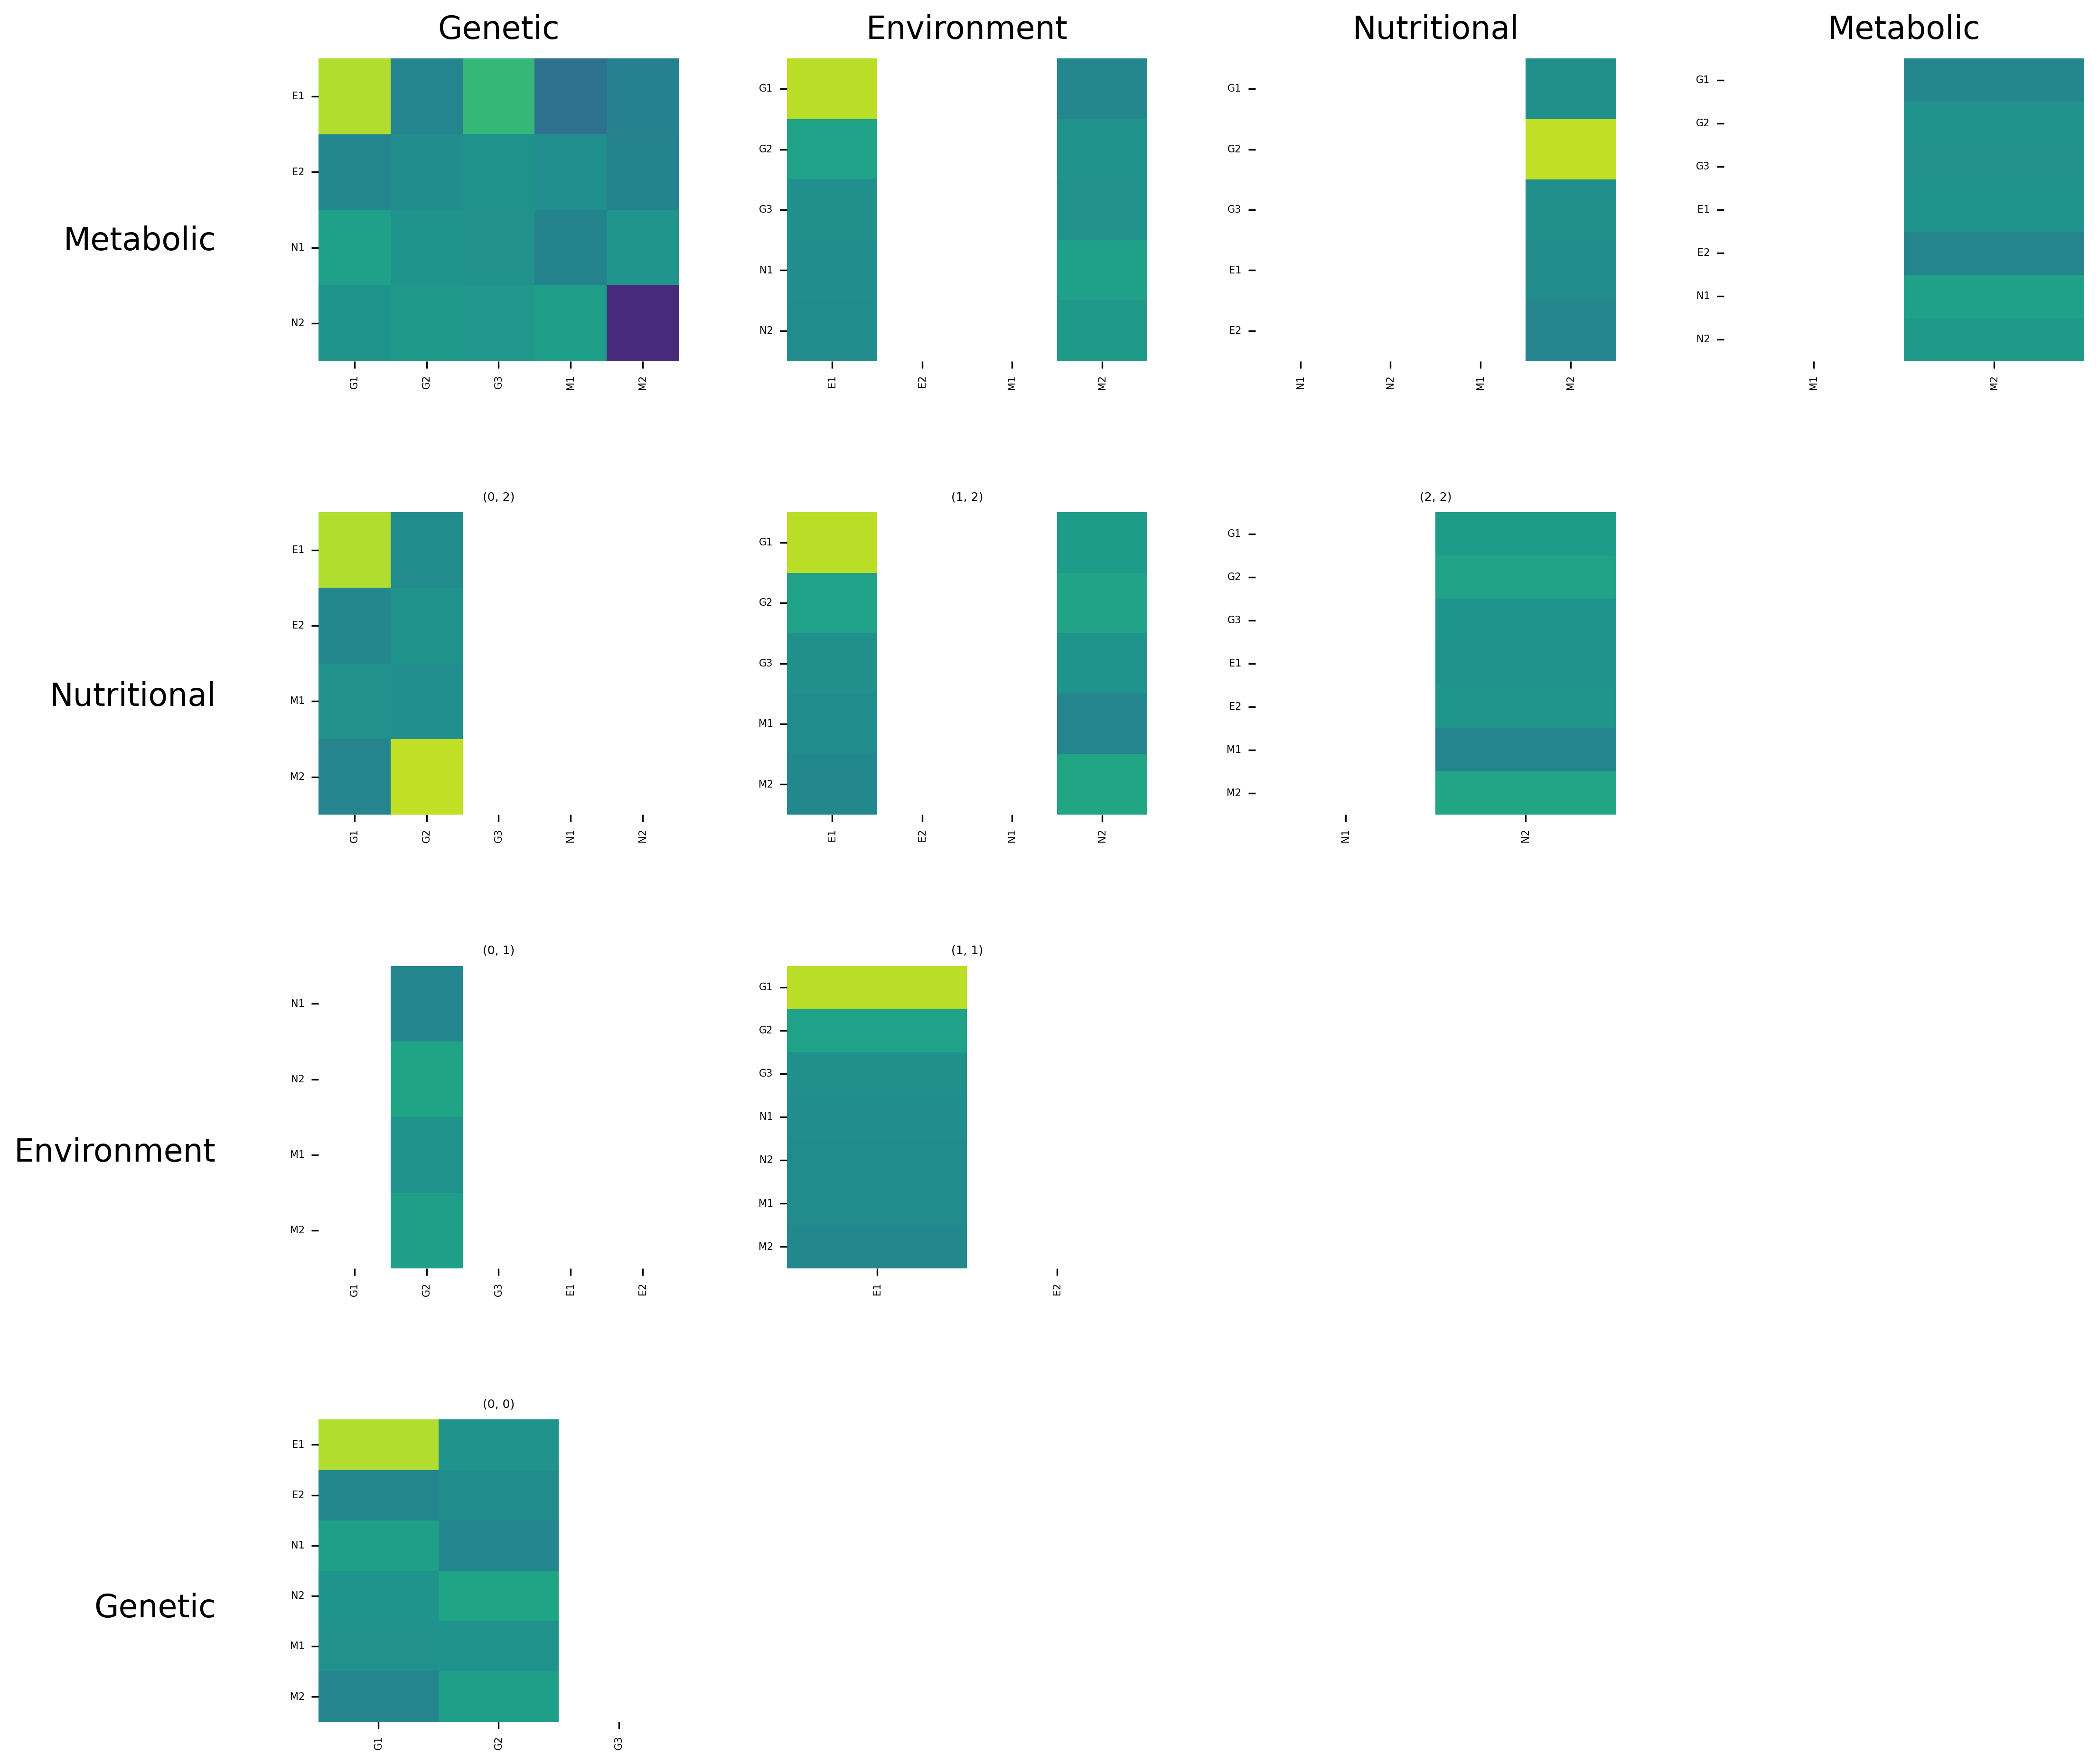

In [49]:
fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    correlation_heatmap_cell,
    plot_type_name="Feature Correlation Heatmaps"
)
plt.show()

fig = plot_cellwise_grid(
    archive_data,
    cell_feature_sets,
    feature_categories,
    correlation_mutable_vs_constraint_cell,
    plot_type_name="Mutable vs Constraint Correlation"
)
plt.show()


### SHAP

#### load models

In [4]:
import torch.nn as nn
import torch
import shap
import pandas as pd
import matplotlib.pyplot as plt

class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 160),# First hidden layer
            nn.Dropout(0.5), 
            nn.ReLU(),
            nn.Linear(160, 1)
        )
    def forward(self, x):
        return self.model(x)


class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            #nn.Dropout(0.1),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)

class PerfectWrapper:
    def __init__(self):
        # Define feature ordering if needed
        self.feature_names = ['G1', 'G2', 'G3', 'E1', 'E2', 'N1', 'N2', 'M1', 'M2']

    def predict(self, X):
        # If input is a DataFrame, convert to NumPy in correct order
        if hasattr(X, 'loc') or hasattr(X, 'iloc'):
            X = X[self.feature_names].values

        G1 = X[:, 0]
        G2 = X[:, 1]
        G3 = X[:, 2]
        E1 = X[:, 3]
        E2 = X[:, 4]
        N1 = X[:, 5]
        N2 = X[:, 6]
        M1 = X[:, 7]
        M2 = X[:, 8]

        y = (
            0.5 * G3 +
            0.7 * E2 +
            0.2 * N1 +
            0.3 * M1 +
            + 1.8 * G1 * E1 #interaction between 2 features
            + 1.8 * G2 * N2 * M2 # higher order interaction
        )
        return y
model_name="mlp_model"
model_path="~/MAP-CF/synthetic/mlp_model.pkl"
model_path = os.path.expanduser(model_path)
X_train_df = pd.read_csv("synthetic/synthetic_train.csv").drop(columns="Unnamed: 0")

if model_path.endswith(".pth"):
    if model_name == "mlp_model":
        input_dim = X_train_df.shape[1]
        wrapper = SimpleMLP(input_dim)
        wrapper.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
        wrapper.eval()
else:
    with open(model_path, "rb") as f:
        wrapper = pickle.load(f)  # sklearn model

#### Perfect model

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

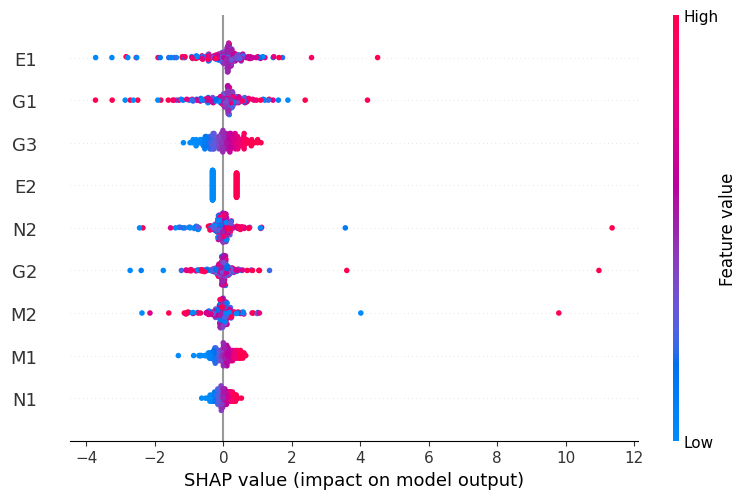

In [5]:


# Load your trained models (already trained)
# Assume you have:
# - linreg_model
# - rf_model
# - X_train_df (your feature matrix for training)
# - X_test_df (your test feature matrix)


# --- Linear Model SHAP ---
model = PerfectWrapper()
# Use TreeExplainer for random forest
#explainer = shap.TreeExplainer(model)
#explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train)
X_val=ref_df.drop(columns="Unnamed: 0")
explainer = shap.KernelExplainer(model.predict, X_val)
#explainer = shap.GradientExplainer(model, X_val)


# Calculate SHAP values
shap_values = explainer.shap_values(X_val)

# Visualize SHAP summary plot for random forest
shap.summary_plot(shap_values, X_val)


#### MLP

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

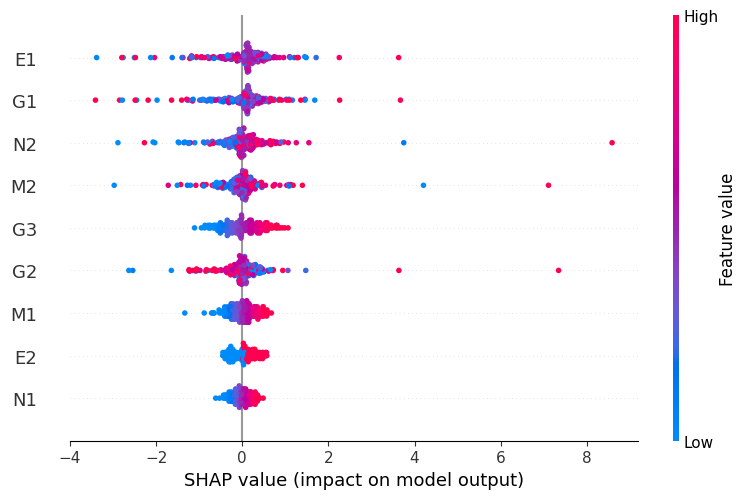

In [6]:
# --- SHAP setup ---

# Define a model prediction function for SHAP
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        output = wrapper(X_tensor).numpy()
    return output
X_val=ref_df.drop(columns="Unnamed: 0")

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_val.values)

# Compute SHAP values
shap_values = explainer.shap_values(X_val.values)  # You can increase nsamples

# --- Plot SHAP summary ---
shap.summary_plot(shap_values[0], X_val, plot_type="dot")
shap_values=shap_values[0]

#### Clustering

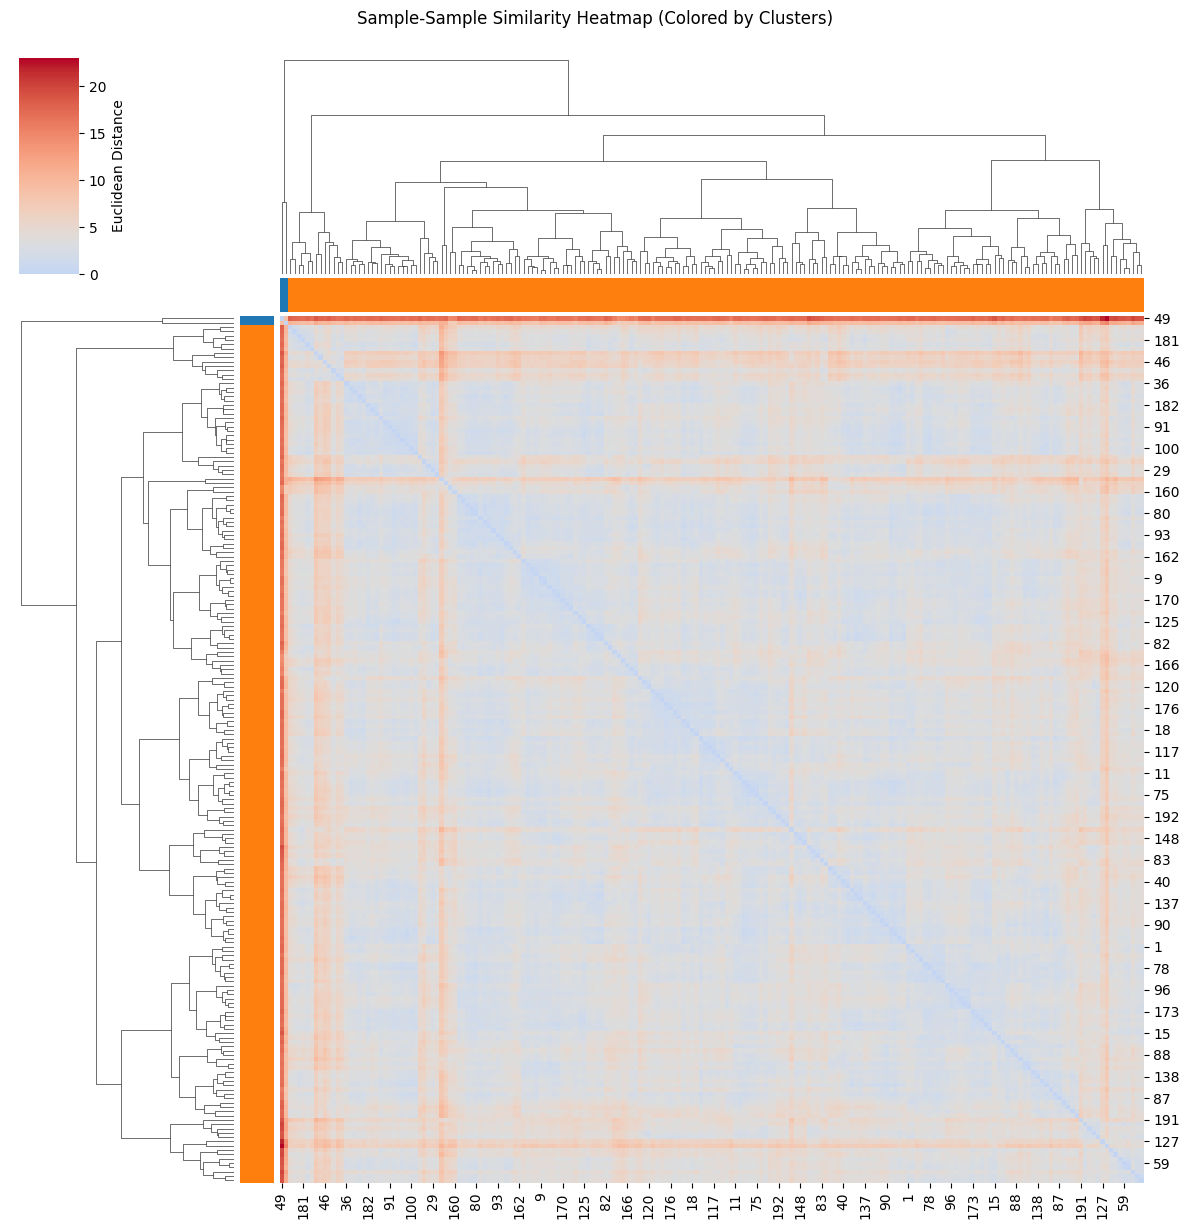

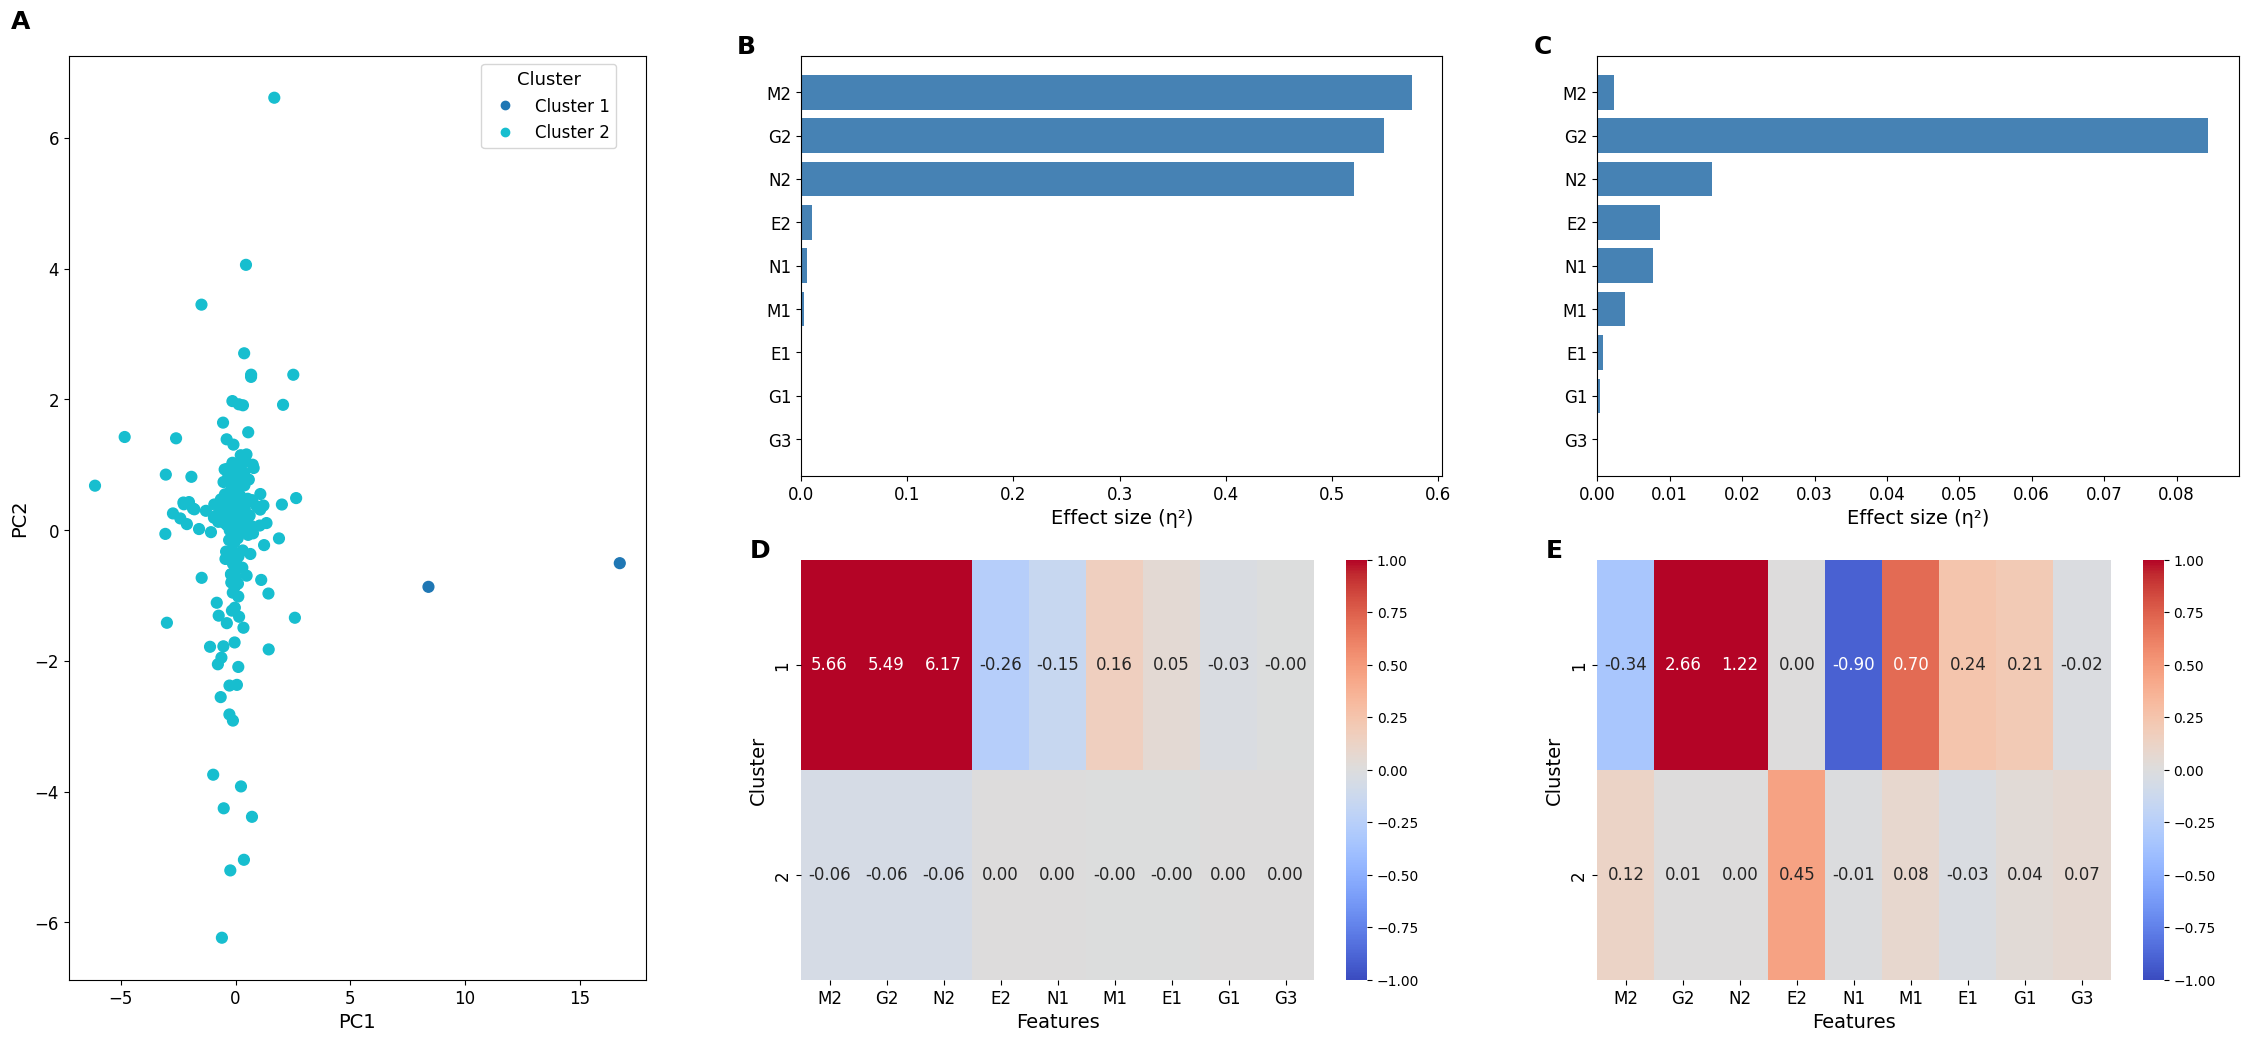

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# --- Assume you have your shap_matrix (n_samples, n_features) ---
shap_matrix = shap_values
# Step 1: Standardize SHAP values
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# Step 2: Compute pairwise distances
pairwise_distances = pdist(shap_matrix_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)

def optimal_hclust_k(X, max_k=5, method='ward', metric='euclidean'):
    """
    Identify the optimal number of clusters for hierarchical clustering
    using silhouette score.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
    - max_k: maximum number of clusters to consider
    - method: linkage method (default: 'ward')
    - metric: distance metric (default: 'euclidean')

    Returns:
    - best_k: int, number of clusters with highest silhouette score
    - best_labels: array of cluster labels for best_k
    - Z: linkage matrix (can be reused)
    """
    Z = linkage(X, method=method, metric=metric)
    best_score = -1
    best_k = None
    best_labels = None

    for k in range(2, max_k + 1):
        labels = fcluster(Z, t=k, criterion='maxclust')
        if len(set(labels)) <= 1:
            continue
        try:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_labels = labels
        except Exception:
            continue

    return best_k, best_labels, Z
'''
# Step 3: Hierarchical clustering
Z = linkage(pairwise_distances, method='ward')

# Step 4: Cut tree into clusters
n_clusters = 8
height = 12
cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
#cluster_labels = fcluster(Z, t=height, criterion='distance')
n_clusters = len(cluster_labels)
# Step 5: Assign colors to cluster labels
palette = sns.color_palette("tab10", n_clusters)
cluster_color_mapping = dict(zip(np.unique(cluster_labels), palette))
row_colors = pd.Series(cluster_labels).map(cluster_color_mapping).to_numpy()

# Step 6: Create clustermap
sns.clustermap(distance_matrix,
                   row_linkage=Z,
                   col_linkage=Z,
                   row_colors=row_colors,
                   col_colors=row_colors,
                   cmap='coolwarm',  # <- makes sure the HEATMAP (distance matrix) is coolwarm!
                   center=np.median(distance_matrix),  # Centering at median distance
                   figsize=(12, 12),
                   cbar_kws={"label": "Euclidean Distance"})

plt.suptitle('Sample-Sample Similarity Heatmap (Colored by Clusters)', y=1.02)
plt.show()
'''
# Step 3: Hierarchical clustering using optimal number of clusters
max_k = 5  # Or any reasonable limit based on your data
best_k, cluster_labels, Z = optimal_hclust_k(shap_matrix_scaled, max_k=max_k, method='ward', metric='euclidean')

# Step 4: Assign colors to cluster labels
n_clusters = len(np.unique(cluster_labels))
palette = sns.color_palette("tab10", n_clusters)
cluster_color_mapping = dict(zip(np.unique(cluster_labels), palette))
row_colors = pd.Series(cluster_labels).map(cluster_color_mapping).to_numpy()

# Step 5: Compute pairwise distance again for the clustermap
pairwise_distances = pdist(shap_matrix_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
Z = linkage(pairwise_distances, method='ward')  # Reuse same linkage as optimal_hclust_k




# Step 6: Create clustermap
sns.clustermap(distance_matrix,
               row_linkage=Z,
               col_linkage=Z,
               row_colors=row_colors,
               col_colors=row_colors,
               cmap='coolwarm',
               center=np.median(distance_matrix),
               figsize=(12, 12),
               cbar_kws={"label": "Euclidean Distance"})

plt.suptitle('Sample-Sample Similarity Heatmap (Colored by Clusters)', y=1.02)
plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# --- Assume these are already defined ---
# - shap_values: SHAP matrix (n_samples, n_features)
# - cluster_labels: cluster assignments (n_samples,)
# - X_val: original unscaled DataFrame (n_samples, n_features)

shap_matrix = shap_values
feature_names = X_val.columns.tolist()

# --- Optional: PCA for 2D projection ---
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)
pca = PCA(n_components=2)
shap_umap = pca.fit_transform(shap_matrix_scaled)

# --- Step 1: η² from SHAP values ---
F_shap, _ = f_classif(shap_matrix, cluster_labels)
eta2_shap = F_shap / (F_shap + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# --- Step 2: η² from raw values ---
F_raw, _ = f_classif(X_val, cluster_labels)
eta2_raw = F_raw / (F_raw + X_val.shape[0] - X_val.shape[1] - 1)

# --- Sort by SHAP η² ---
sorted_idx = np.argsort(-eta2_shap)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2_shap = eta2_shap[sorted_idx][:10]
top_eta2_raw = eta2_raw[sorted_idx][:10]  # same feature order

# --- Step 3: Mean SHAP & Raw values per cluster ---
cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

X_with_cluster = X_val.copy()
X_with_cluster['cluster'] = cluster_labels
mean_raw_by_cluster = X_with_cluster.groupby('cluster').mean()



fig = plt.figure(figsize=(28, 12))  # slightly larger overall figure
gs = fig.add_gridspec(2, 3, width_ratios=[1.8, 2, 2])  # make Panel A thinner

# Panel A: PCA scatter
ax0 = fig.add_subplot(gs[:, 0])
scatter = ax0.scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=60)
ax0.set_xlabel('PC1', fontsize=14)
ax0.set_ylabel('PC2', fontsize=14)
ax0.tick_params(labelsize=12)
unique_clusters = np.unique(cluster_labels)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=f'Cluster {i}')
    for i in unique_clusters
]
ax0.legend(handles=handles, title='Cluster', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=12, title_fontsize=13)
ax0.text(-0.1, 1.05, "A", transform=ax0.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel B: SHAP η² barplot
ax1 = fig.add_subplot(gs[0, 1])
ax1.barh(top_features, top_eta2_shap, color='steelblue')
ax1.set_xlabel('Effect size (η²)', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.invert_yaxis()
ax1.text(-0.1, 1.05, "B", transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel C: Raw η² barplot
ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(top_features, top_eta2_raw, color='steelblue')
ax2.set_xlabel('Effect size (η²)', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.invert_yaxis()
ax2.text(-0.1, 1.05, "C", transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel D: SHAP heatmap
ax3 = fig.add_subplot(gs[1, 1])
sns.heatmap(mean_shap_by_cluster[top_features], cmap='coolwarm', center=0,
            annot=True, fmt=".2f", ax=ax3, vmax=1, vmin=-1, cbar=True, annot_kws={"size": 12})
ax3.set_xlabel('Features', fontsize=14)
ax3.set_ylabel('Cluster', fontsize=14)
ax3.tick_params(labelsize=12)
ax3.text(-0.1, 1.05, "D", transform=ax3.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel E: Raw heatmap
ax4 = fig.add_subplot(gs[1, 2])
sns.heatmap(mean_raw_by_cluster[top_features], cmap='coolwarm',
            annot=True, fmt=".2f", ax=ax4, vmax=1, vmin=-1, cbar=True, annot_kws={"size": 12})
ax4.set_xlabel('Features', fontsize=14)
ax4.set_ylabel('Cluster', fontsize=14)
ax4.tick_params(labelsize=12)
ax4.text(-0.1, 1.05, "E", transform=ax4.transAxes, fontsize=18, fontweight='bold', va='top')

fig.subplots_adjust(wspace=0.25)
plt.show()


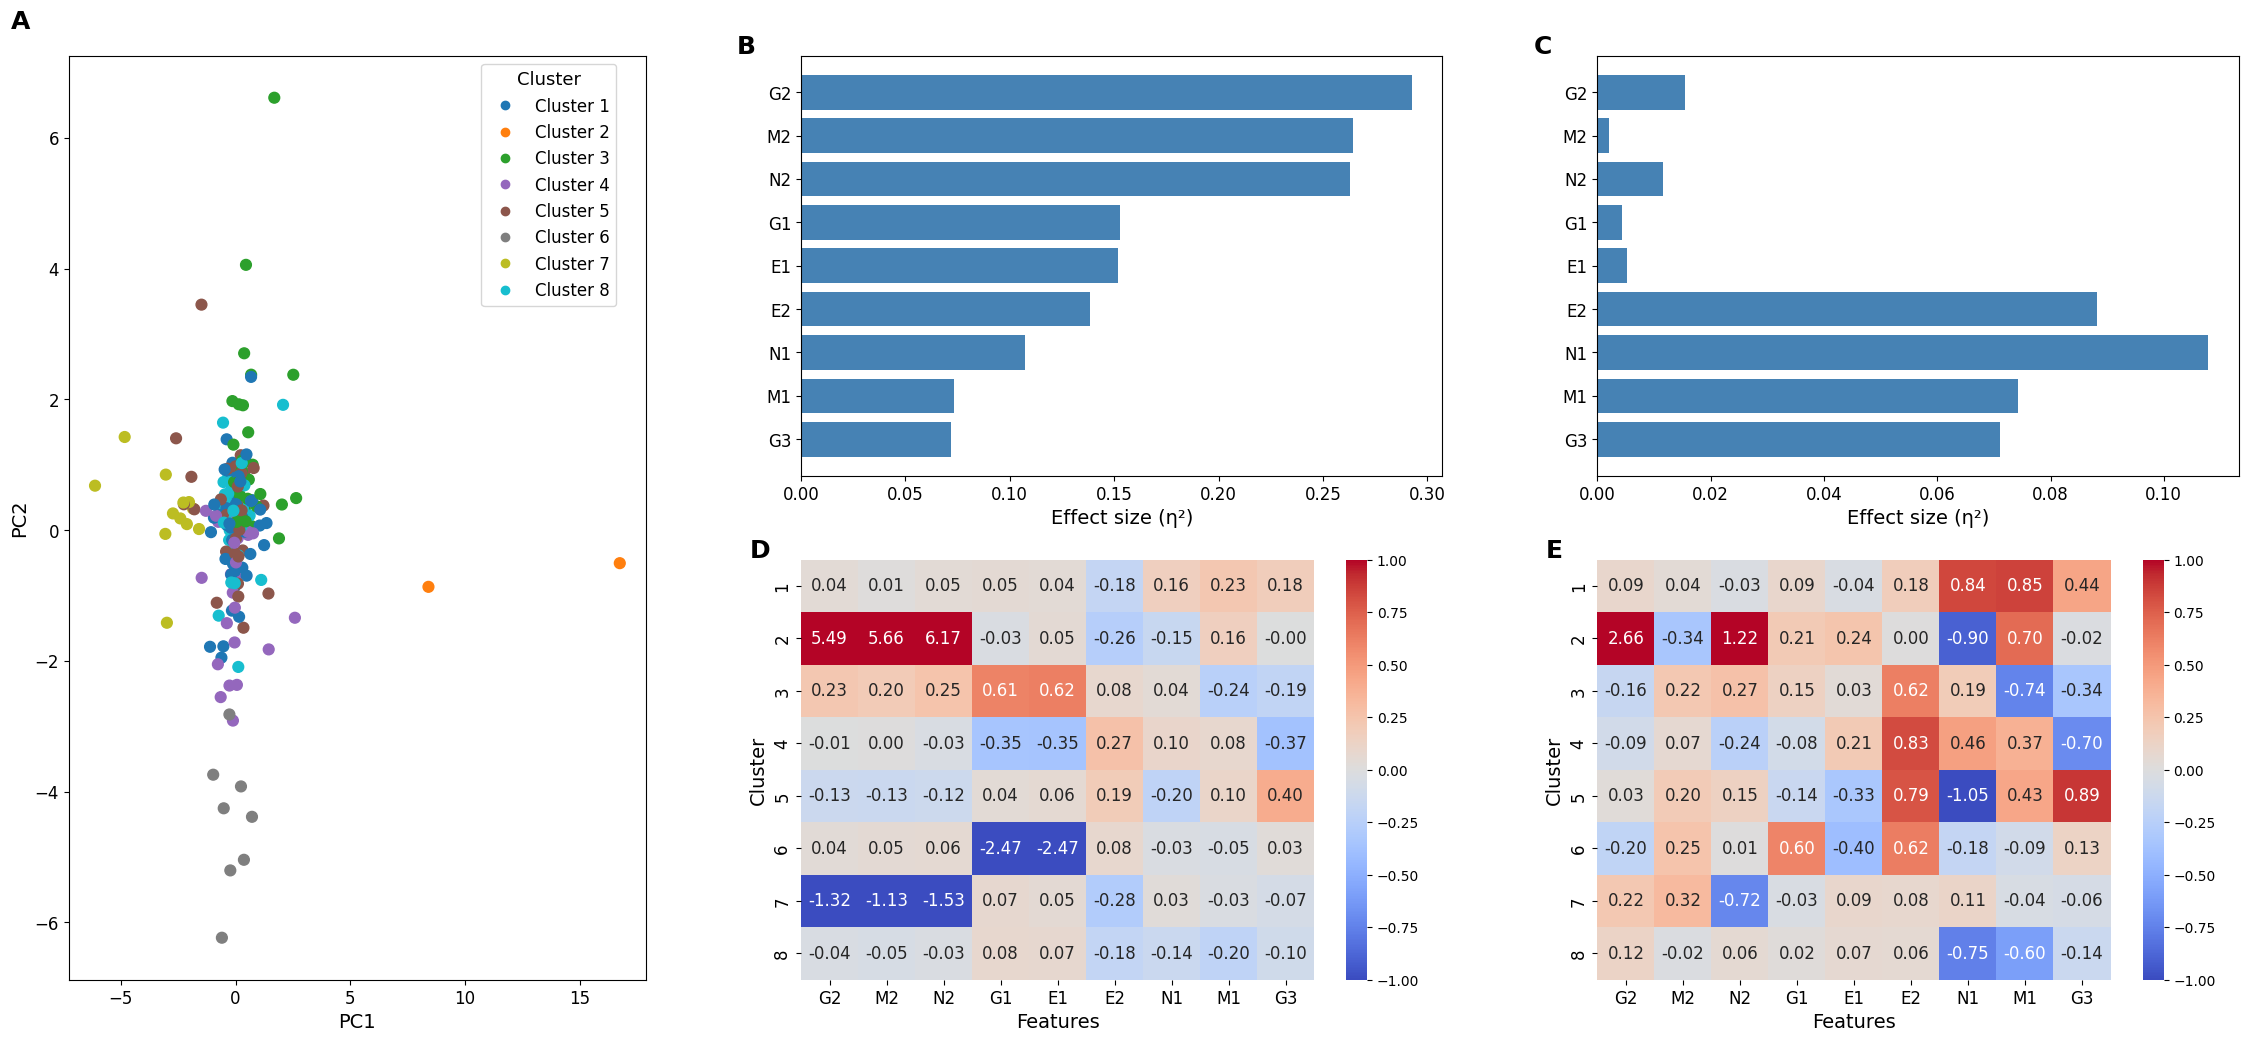

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# --- Assume you have your shap_matrix (n_samples, n_features) ---
shap_matrix = shap_values
# Step 1: Standardize SHAP values
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif

# --- Assume these are already defined ---
# - shap_values: SHAP matrix (n_samples, n_features)
# - cluster_labels: cluster assignments (n_samples,)
# - X_val: original unscaled DataFrame (n_samples, n_features)

shap_matrix = shap_values
feature_names = X_val.columns.tolist()

# --- Optional: PCA for 2D projection ---
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)
pca = PCA(n_components=2)
shap_umap = pca.fit_transform(shap_matrix_scaled)
def optimal_clusters(X, max_k=5):
    """Determines the optimal number of clusters using silhouette score."""
    if X.shape[0] < 3:
        return 1, -1  # Not enough samples

    best_k = 2
    best_score = -1

    for k in range(2, min(max_k, X.shape[0]) + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels) if k > 1 else -1
        if score > best_score:
            best_score = score
            best_k = k
            best_labels=labels

    return best_k, best_labels

kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(shap_matrix_scaled)
cluster_labels = cluster_labels + 1  # Shift cluster labels to start from 1

# --- Step 1: η² from SHAP values ---
F_shap, _ = f_classif(shap_matrix, cluster_labels)
eta2_shap = F_shap / (F_shap + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# --- Step 2: η² from raw values ---
F_raw, _ = f_classif(X_val, cluster_labels)
eta2_raw = F_raw / (F_raw + X_val.shape[0] - X_val.shape[1] - 1)

# --- Sort by SHAP η² ---
sorted_idx = np.argsort(-eta2_shap)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2_shap = eta2_shap[sorted_idx][:10]
top_eta2_raw = eta2_raw[sorted_idx][:10]  # same feature order

# --- Step 3: Mean SHAP & Raw values per cluster ---
cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

X_with_cluster = X_val.copy()
X_with_cluster['cluster'] = cluster_labels
mean_raw_by_cluster = X_with_cluster.groupby('cluster').mean()



fig = plt.figure(figsize=(28, 12))  # slightly larger overall figure
gs = fig.add_gridspec(2, 3, width_ratios=[1.8, 2, 2])  # make Panel A thinner

# Panel A: PCA scatter
ax0 = fig.add_subplot(gs[:, 0])
scatter = ax0.scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=60)
ax0.set_xlabel('PC1', fontsize=14)
ax0.set_ylabel('PC2', fontsize=14)
ax0.tick_params(labelsize=12)
unique_clusters = np.unique(cluster_labels)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=f'Cluster {i}')
    for i in unique_clusters
]
ax0.legend(handles=handles, title='Cluster', bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=12, title_fontsize=13)
ax0.text(-0.1, 1.05, "A", transform=ax0.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel B: SHAP η² barplot
ax1 = fig.add_subplot(gs[0, 1])
ax1.barh(top_features, top_eta2_shap, color='steelblue')
ax1.set_xlabel('Effect size (η²)', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.invert_yaxis()
ax1.text(-0.1, 1.05, "B", transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel C: Raw η² barplot
ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(top_features, top_eta2_raw, color='steelblue')
ax2.set_xlabel('Effect size (η²)', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.invert_yaxis()
ax2.text(-0.1, 1.05, "C", transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel D: SHAP heatmap
ax3 = fig.add_subplot(gs[1, 1])
sns.heatmap(mean_shap_by_cluster[top_features], cmap='coolwarm', center=0,
            annot=True, fmt=".2f", ax=ax3, vmax=1, vmin=-1, cbar=True, annot_kws={"size": 12})
ax3.set_xlabel('Features', fontsize=14)
ax3.set_ylabel('Cluster', fontsize=14)
ax3.tick_params(labelsize=12)
ax3.text(-0.1, 1.05, "D", transform=ax3.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel E: Raw heatmap
ax4 = fig.add_subplot(gs[1, 2])
sns.heatmap(mean_raw_by_cluster[top_features], cmap='coolwarm',
            annot=True, fmt=".2f", ax=ax4, vmax=1, vmin=-1, cbar=True, annot_kws={"size": 12})
ax4.set_xlabel('Features', fontsize=14)
ax4.set_ylabel('Cluster', fontsize=14)
ax4.tick_params(labelsize=12)
ax4.text(-0.1, 1.05, "E", transform=ax4.transAxes, fontsize=18, fontweight='bold', va='top')

fig.subplots_adjust(wspace=0.25)
plt.show()


#### KDE

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


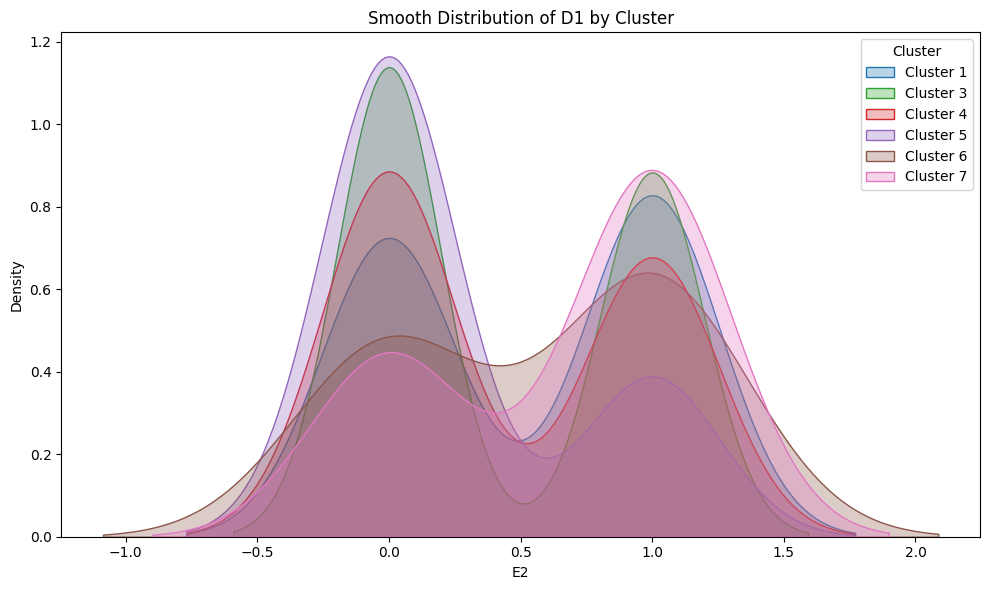

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare DataFrame ---
plot_df = X_val.copy()
plot_df['cluster'] = cluster_labels
feature_of_interest='E2'
plot_df[feature_of_interest] = X_val[feature_of_interest]  # ensure this is the correct column

# --- Plot KDE for each cluster ---
plt.figure(figsize=(10, 6))
for cluster in sorted(plot_df['cluster'].unique()):
    subset = plot_df[plot_df['cluster'] == cluster]
    sns.kdeplot(subset[feature_of_interest], label=f'Cluster {cluster}', fill=True, alpha=0.3)

plt.title('Smooth Distribution of D1 by Cluster')
plt.xlabel(feature_of_interest)
plt.ylabel('Density')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
